# Predicting Hotel Cancellations

Apex Pattern Deployers

- Marjorie Kinney *m20210647*
- Bruno Mendes *m20210627*
- Lucas Neves *m20211020*
- Farina Pontejos *m20210649*

Business Cases for Data Science

NOVA Information Management School

March 2022




## Initial Setup

In [21]:
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats.mstats import winsorize
import statsmodels as sm
from math import ceil
from datetime import timedelta
import os

#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

import graphviz

import warnings
warnings.filterwarnings('ignore')

from matplotlib.colors import LinearSegmentedColormap

In [22]:
#! python -m pip install graphviz

In [23]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LassoCV

from sklearn.model_selection import train_test_split

from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif, f_regression


from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz

from sklearn import preprocessing

from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PowerTransformer

from sklearn.metrics import f1_score

from sklearn.neural_network import MLPClassifier

from sklearn.impute import KNNImputer

In [24]:
## Note versions used

print('Pandas version ',pd.__version__)
print('Numpy version ',np.__version__)
print('Scipy version ',sp.__version__)
print('Seaborn version ',sns.__version__)


Pandas version  1.3.4
Numpy version  1.21.2
Scipy version  1.7.1
Seaborn version  0.11.2


In [25]:
COLORS = ['#22446d', '#446f8b', '#689ea6', '#94cdbc', '#e6f9af', '#f5b68e', '#eb756f', '#cb3553', '#93003a']

CAT_COLORS = ['#22446D', '#6ABB5D', '#F3E97B', '#FC9E4F', '#AB2346']
CONTRAST_COLORS = [COLORS[i] for i in range(len(COLORS)) if (i%2) == 0]

DIV_COLORS = COLORS.copy()

DEFAULT_PALETTE = sns.color_palette(COLORS)
CONTRAST_PALETTE = sns.color_palette(CONTRAST_COLORS)
DIVERGENT_PALETTE = sns.color_palette(DIV_COLORS)
CAT_PALETTE = sns.color_palette(CAT_COLORS)


DIV_CMAP = LinearSegmentedColormap.from_list("div_colors", DIV_COLORS)
CAT_CMAP = LinearSegmentedColormap.from_list("cat_colors", CAT_COLORS)


SHOW_PLOTS = True
SAVE_PLOTS = False
RANDOM_STATE = 9

show_plots = True
img_counter = 0
random_state = 0

IMG_PATH = 'imgs/'
DATA_PATH = 'data/'


In [26]:
sns.set(style="white")

sns.set_context("paper")
sns.set_palette(DEFAULT_PALETTE)


plt.rcParams['figure.dpi'] = 70

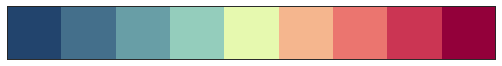

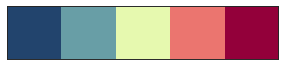

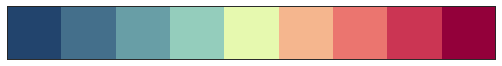

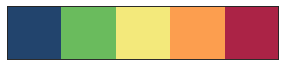

In [27]:
sns.palplot(DEFAULT_PALETTE)
sns.palplot(CONTRAST_PALETTE)
sns.palplot(DIVERGENT_PALETTE)
sns.palplot(CAT_PALETTE)
plt.show()

## Define some helper functions

In [28]:
def save_fig(title, fig):
    if SAVE_PLOTS == True:
        fn = IMG_PATH + title.replace(' ','-') + '.png'
        fig.savefig(fn, bbox_inches='tight')
        


In [29]:
## Function to plot histograms of numeric features for specified dataframe
def plot_histograms_boxplots(df, features, rows=4, title = "Histograms of Numeric Variables"):
    if SHOW_PLOTS:
        cols = ceil(len(features) / rows)
        fig = plt.figure(figsize=(4*cols,4*rows),
                         constrained_layout=True)
        
        subfigs = fig.subfigures(rows, cols)
    
        for subf, feat in zip(subfigs.flatten(), features):
            axs = subf.subplots(2, 1, sharex=True, \
                                gridspec_kw={'height_ratios': [4,1]})
        
            axs[0].hist(df[feat], color=COLORS[0])
            axs[0].set_ylabel(None)
            axs[0].set_title(feat, y=1, fontsize=6*rows)
        
            axs[1].set_xlabel(None)
            flierprops = dict(markerfacecolor='None', markersize=6,  markeredgecolor=COLORS[0])
            sns.boxplot(x=df[feat], ax=axs[1], color=COLORS[0], flierprops=flierprops)
            axs[1].set_xlabel(None)

            subf.suptitle(None)
        
        plt.suptitle(title, fontsize=8*rows)
        if SAVE_PLOTS:
            save_fig(title, fig)
        
        plt.show()
    else:
        print("show_plots is currently set to False")

In [30]:
def getIQR(df, colname) :
    q25 = df[colname].quantile(.25)
    q75 = df[colname].quantile(.75)
    iqr = (q75 - q25)

    upper_lim = q75 + 2 * iqr
    lower_lim = q25 - 2 * iqr

    above_ul = df.loc[df[colname]>upper_lim]
    below_ll = df.loc[df[colname]<lower_lim]
    
    if len(above_ul) > 0 :
        print(str(len(above_ul)) + " or " + str(round((100*len(above_ul)/len(df)),4)) + "% of rows are above the UL ["+ colname + "].")
    if len(below_ll) > 0 :
        print(str(len(below_ll)) + " or " + str(round((100*len(below_ll)/len(df)),4)) + "% of rows are below the LL ["+ colname + "].")

    
    return upper_lim, lower_lim, len(above_ul), len(below_ll)




In [33]:
df = pd.read_csv('H2.csv')

## Remove last row
#df.drop(df.tail(1).index,inplace=True)
#df['Custid'] = df['Custid'].astype(int)
#df.set_index('Custid', inplace=True)

df_original = df.copy(deep=True)

df.head(3)

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,...,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate
0,0,6,2015,July,27,1,0,2,1,0.0,...,No Deposit,6,NULL,0,Transient,0.0,0,0,Check-Out,2015-07-03
1,1,88,2015,July,27,1,0,4,2,0.0,...,No Deposit,9,NULL,0,Transient,76.5,0,1,Canceled,2015-07-01
2,1,65,2015,July,27,1,0,4,1,0.0,...,No Deposit,9,NULL,0,Transient,68.0,0,1,Canceled,2015-04-30


## Data Preprocessing

### Convert types

In [34]:
MONTHS = ['January', 'February', 'March', 'April', 'May','June',
          'July','August','September','October','November','December']

MONTH_NUMS = [i+1 for i in range(12)]

df['ArrivalDateMonthNumber'] = df['ArrivalDateMonth'].replace(to_replace=MONTHS, value=MONTH_NUMS)
df.loc[:,['ArrivalDateMonth','ArrivalDateMonthNumber']]

,ArrivalDateMonth,ArrivalDateMonthNumber
0,July,7
1,July,7
2,July,7
3,July,7
4,July,7
...,...,...
79325,August,8
79326,August,8
79327,August,8
79328,August,8


In [35]:
df['ArrivalDate'] = df['ArrivalDateYear'].astype(str) + '-' + df['ArrivalDateMonthNumber'].astype(str) + '-' + df['ArrivalDateDayOfMonth'].astype(str)
df['ArrivalDate'] = pd.to_datetime(df['ArrivalDate'])
# df['ArrivalDate']

In [36]:
df['ReservationStatusDate'] = pd.to_datetime(df['ReservationStatusDate'])
# print(df.dtypes)


### Check nulls

In [37]:
df['Company'] = df['Company'].replace('       NULL', np.nan)

In [38]:
df['Company'][0]

nan

In [39]:
df.isna().sum()

IsCanceled                         0
LeadTime                           0
ArrivalDateYear                    0
ArrivalDateMonth                   0
ArrivalDateWeekNumber              0
ArrivalDateDayOfMonth              0
StaysInWeekendNights               0
StaysInWeekNights                  0
Adults                             0
Children                           4
Babies                             0
Meal                               0
Country                           24
MarketSegment                      0
DistributionChannel                0
IsRepeatedGuest                    0
PreviousCancellations              0
PreviousBookingsNotCanceled        0
ReservedRoomType                   0
AssignedRoomType                   0
BookingChanges                     0
DepositType                        0
Agent                              0
Company                        75641
DaysInWaitingList                  0
CustomerType                       0
ADR                                0
R

Drop Company because too many nulls

In [40]:
df.drop(columns=['Company'],inplace=True)

Impute missing values for Country and Children with modes

In [41]:
df['Country'].fillna(value=df['Country'].mode()[0], inplace=True)

In [42]:
df['Children'].fillna(value=df['Children'].mode()[0], inplace=True)

In [43]:
#df.isna().sum()

### Check duplicates

In [44]:
## duplicates kept
df_hasdups = df.copy()

## duplicated rows
df_dups = df[df.duplicated(keep=False)]

## duplicates removed
df.drop_duplicates(keep='first', inplace=True)

### Separate numeric and non-numeric features

In [45]:
num_feats = df.select_dtypes(include=[np.number]).columns.tolist()
num_feats

['IsCanceled',
 'LeadTime',
 'ArrivalDateYear',
 'ArrivalDateWeekNumber',
 'ArrivalDateDayOfMonth',
 'StaysInWeekendNights',
 'StaysInWeekNights',
 'Adults',
 'Children',
 'Babies',
 'IsRepeatedGuest',
 'PreviousCancellations',
 'PreviousBookingsNotCanceled',
 'BookingChanges',
 'DaysInWaitingList',
 'ADR',
 'RequiredCarParkingSpaces',
 'TotalOfSpecialRequests',
 'ArrivalDateMonthNumber']

In [46]:
cat_feats = df.columns.drop(num_feats).to_list()
cat_feats

['ArrivalDateMonth',
 'Meal',
 'Country',
 'MarketSegment',
 'DistributionChannel',
 'ReservedRoomType',
 'AssignedRoomType',
 'DepositType',
 'Agent',
 'CustomerType',
 'ReservationStatus',
 'ReservationStatusDate',
 'ArrivalDate']

In [47]:
num_feats.remove('IsCanceled')
num_feats

['LeadTime',
 'ArrivalDateYear',
 'ArrivalDateWeekNumber',
 'ArrivalDateDayOfMonth',
 'StaysInWeekendNights',
 'StaysInWeekNights',
 'Adults',
 'Children',
 'Babies',
 'IsRepeatedGuest',
 'PreviousCancellations',
 'PreviousBookingsNotCanceled',
 'BookingChanges',
 'DaysInWaitingList',
 'ADR',
 'RequiredCarParkingSpaces',
 'TotalOfSpecialRequests',
 'ArrivalDateMonthNumber']

### Check Outliers

### Check strange values

In [48]:
## Fix Country Code 'CN' as CHN
df.loc[df['Country']=='CN',['Country']] = 'CHN'
df.loc[df['Country']=='CN',['Country']]


,Country


## Time Series Analysis

In [49]:
df.columns

Index(['IsCanceled', 'LeadTime', 'ArrivalDateYear', 'ArrivalDateMonth',
       'ArrivalDateWeekNumber', 'ArrivalDateDayOfMonth',
       'StaysInWeekendNights', 'StaysInWeekNights', 'Adults', 'Children',
       'Babies', 'Meal', 'Country', 'MarketSegment', 'DistributionChannel',
       'IsRepeatedGuest', 'PreviousCancellations',
       'PreviousBookingsNotCanceled', 'ReservedRoomType', 'AssignedRoomType',
       'BookingChanges', 'DepositType', 'Agent', 'DaysInWaitingList',
       'CustomerType', 'ADR', 'RequiredCarParkingSpaces',
       'TotalOfSpecialRequests', 'ReservationStatus', 'ReservationStatusDate',
       'ArrivalDateMonthNumber', 'ArrivalDate'],
      dtype='object')

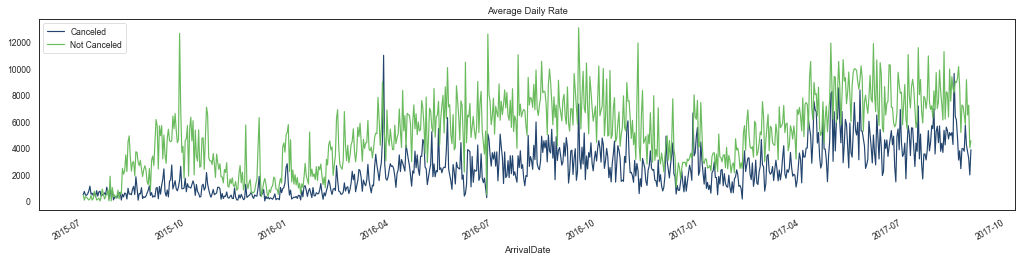

In [50]:
fig, ax = plt.subplots(figsize=(18,4))

df_ts = df.copy()

df_ts['ADR_Diff'] = df_ts['ADR']
df_ts.loc[df_ts['IsCanceled']==True, ['ADR_Diff']] *= 1


#df_ts_diff = df_ts.groupby(['ArrivalDate'])\
#    .sum()['ADR_Diff'].plot(ax=ax, color=CAT_COLORS[-1], label='Difference')

df_ts.loc[df['IsCanceled']==True,:].groupby(['ArrivalDate'])\
    .sum()['ADR_Diff'].plot(ax=ax, color=CAT_COLORS[0], label='Canceled')

df_ts.loc[df['IsCanceled']==False,:].groupby(['ArrivalDate'])\
    .sum()['ADR_Diff'].plot(ax=ax, color=CAT_COLORS[1], label='Not Canceled')


## Plot percent canceled

plt.title("Average Daily Rate")

plt.legend()
plt.show()

In [51]:
df_ts.loc[df_ts['ArrivalDate']=='2016-04-01',['ArrivalDate','ADR','ADR_Diff','IsCanceled']].groupby(['IsCanceled']).sum()

,ADR,ADR_Diff
IsCanceled,,
0,4587.76,4587.76
1,2604.71,2604.71


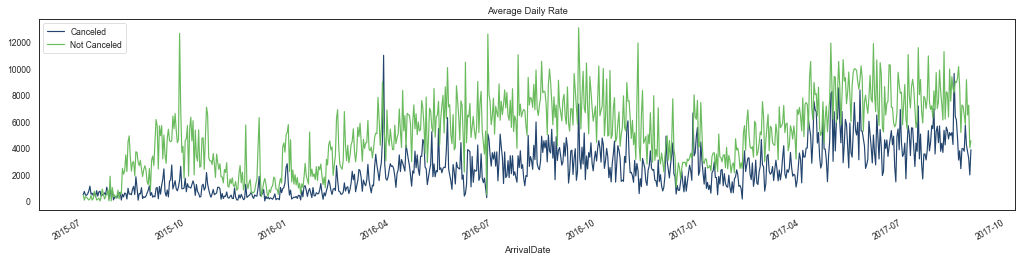

In [52]:
fig, ax = plt.subplots(figsize=(18,4))

df_ts = df.copy()

df_ts['ADR_Diff'] = df_ts['ADR']
df_ts.loc[df_ts['IsCanceled']==True, ['ADR_Diff']] *= 1


#df_ts_diff = df_ts.groupby(['ArrivalDate'])\
#    .sum()['ADR_Diff'].plot(ax=ax, color=CAT_COLORS[-1], label='Difference')

df_ts.loc[df['IsCanceled']==True,:].groupby(['ArrivalDate'])\
    .sum()['ADR_Diff'].plot(ax=ax, color=CAT_COLORS[0], label='Canceled')

df_ts.loc[df['IsCanceled']==False,:].groupby(['ArrivalDate'])\
    .sum()['ADR_Diff'].plot(ax=ax, color=CAT_COLORS[1], label='Not Canceled')


## Plot percent canceled

plt.title("Average Daily Rate")

plt.legend()
plt.show()

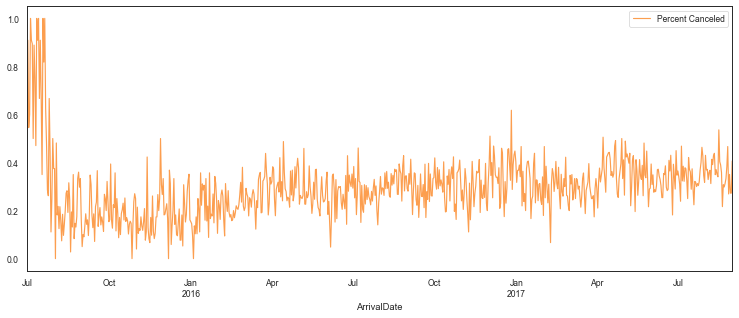

In [53]:
df_ts2 = df.groupby(['ArrivalDate','IsCanceled']).size().unstack()
df_ts2 = df_ts2.T.reset_index(drop=True).T.replace(np.nan,0)
df_ts2['total'] = df_ts2[0]+df_ts2[1]
df_ts2['diff'] = df_ts2[0]-df_ts2[1]

df_ts2['percentCanceled'] = df_ts2[1]/df_ts2['total']

fig, ax = plt.subplots(figsize=(13,5))

df_ts2['percentCanceled'].plot(ax=ax, color=CAT_COLORS[3], label='Percent Canceled')

plt.legend()
plt.show()

In [54]:
import statsmodels.api as sm


In [55]:
endog = df_ts2['percentCanceled']
endog.index = pd.period_range('2015-07-01','2017-08-31',freq='D')

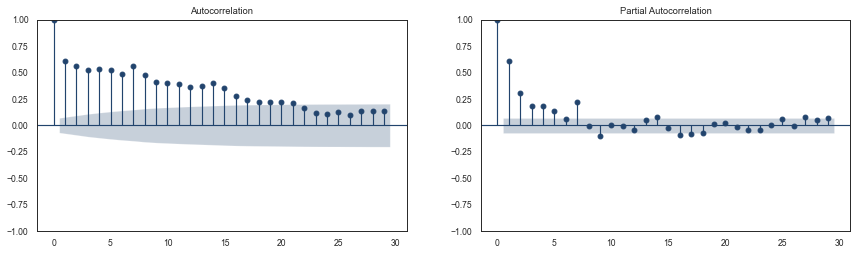

In [56]:
fig, axes = plt.subplots(1, 2, figsize=(15,4))

sm.graphics.tsa.plot_acf(endog, ax=axes[0])
sm.graphics.tsa.plot_pacf(endog, method="ywm", ax=axes[1])

plt.show()

In [57]:
## Construct SARIMAX Model

## Remove L6 as not significant
# mod = sm.tsa.SARIMAX(endog, order=([1, 2, 3, 4, 5, 6, 7], 0, 0), trend='c')

# Estimate the parameters
# res = mod.fit()

# endog_trim = endog.loc[:'2017-02-15']

## Construct the model on trimmed data
## Remove L6 as not significant
# mod_trim = sm.tsa.SARIMAX(endog_trim, order=([1, 2, 3, 4, 5, 7], 0, 0), trend='ct')

## Estimate the parameters
# res_trim = mod_trim.fit()

In [58]:
## Plots
# fig, ax = plt.subplots(figsize=(15, 5))

# Plot the data (here we are subsetting it to get a better look at the forecasts)
## endog[:'2017-03-01'].plot(ax=ax, color=COLORS[1])

# Construct the forecasts

## Don't use these
#fcast = res.get_prediction(start='2017-09-01', end='2018-7-31').summary_frame()
#fcast = res.get_prediction(start='2017-02-16', end='2017-8-30').summary_frame()
#fcast = res_trim.get_prediction(start='2017-02-16', end='2017-8-30').summary_frame()

## Use this
#fcast = res_trim.get_prediction(start='2017-02-16', end='2017-02-28').summary_frame()


#ax.fill_between(fcast.index, fcast['mean_ci_lower'], fcast['mean_ci_upper'], color='k', alpha=0.1);
#fcast['mean'].plot(ax=ax, color='r')

#plt.show()

## Feature Engineering

### Add regions for countries

In [59]:
## Data from https://raw.githubusercontent.com/lukes/ISO-3166-Countries-with-Regional-Codes/master/all/all.csv

In [60]:
## Fix TMP >> TLS
df.loc[df['Country']=='TMP',['Country']] = 'TLS'

In [63]:
country_info = pd.read_csv('country_info.csv')
country_info.head(3)


,name,alpha-2,alpha-3,country-code,iso_3166-2,region,sub-region,intermediate-region,region-code,sub-region-code,intermediate-region-code
0,Afghanistan,AF,AFG,4,ISO 3166-2:AF,Asia,Southern Asia,NaN,142.0,34.0,NaN
1,Åland Islands,AX,ALA,248,ISO 3166-2:AX,Europe,Northern Europe,NaN,150.0,154.0,NaN
2,Albania,AL,ALB,8,ISO 3166-2:AL,Europe,Southern Europe,NaN,150.0,39.0,NaN


In [64]:
# country_info.isna().sum()
# Drop nan region: Antarctica is not in dataset

In [65]:
country_info = country_info.loc[~country_info['region'].isna(),:]

In [66]:
df = pd.merge(df,country_info[['alpha-3','region','sub-region']],
              left_on='Country', right_on='alpha-3',
              how='left').drop(columns=['alpha-3'])

In [67]:
cat_feats.append('region')
cat_feats.append('sub-region')

In [68]:
df.loc[df['Country']=='ATA',['region']] = 'Antarctica'
df.loc[df['Country']=='ATA',['sub-region']] = 'Antarctica'

In [69]:
df.isna().sum()

IsCanceled                     0
LeadTime                       0
ArrivalDateYear                0
ArrivalDateMonth               0
ArrivalDateWeekNumber          0
ArrivalDateDayOfMonth          0
StaysInWeekendNights           0
StaysInWeekNights              0
Adults                         0
Children                       0
Babies                         0
Meal                           0
Country                        0
MarketSegment                  0
DistributionChannel            0
IsRepeatedGuest                0
PreviousCancellations          0
PreviousBookingsNotCanceled    0
ReservedRoomType               0
AssignedRoomType               0
BookingChanges                 0
DepositType                    0
Agent                          0
DaysInWaitingList              0
CustomerType                   0
ADR                            0
RequiredCarParkingSpaces       0
TotalOfSpecialRequests         0
ReservationStatus              0
ReservationStatusDate          0
ArrivalDat

### Add Season column

In [70]:
## From https://stackoverflow.com/questions/16139306/determine-season-given-timestamp-in-python-using-datetime

def season_of_date(date):
    year = str(date.year)
    seasons = {'spring': pd.date_range(start='21/03/'+year, end='20/06/'+year),
               'summer': pd.date_range(start='21/06/'+year, end='22/09/'+year),
               'autumn': pd.date_range(start='23/09/'+year, end='20/12/'+year)}
    if date in seasons['spring']:
        return 'spring'
    if date in seasons['summer']:
        return 'summer'
    if date in seasons['autumn']:
        return 'autumn'
    else:
        return 'winter'


In [71]:
df['Season'] = df['ArrivalDate'].map(season_of_date)

In [72]:
df.columns

Index(['IsCanceled', 'LeadTime', 'ArrivalDateYear', 'ArrivalDateMonth',
       'ArrivalDateWeekNumber', 'ArrivalDateDayOfMonth',
       'StaysInWeekendNights', 'StaysInWeekNights', 'Adults', 'Children',
       'Babies', 'Meal', 'Country', 'MarketSegment', 'DistributionChannel',
       'IsRepeatedGuest', 'PreviousCancellations',
       'PreviousBookingsNotCanceled', 'ReservedRoomType', 'AssignedRoomType',
       'BookingChanges', 'DepositType', 'Agent', 'DaysInWaitingList',
       'CustomerType', 'ADR', 'RequiredCarParkingSpaces',
       'TotalOfSpecialRequests', 'ReservationStatus', 'ReservationStatusDate',
       'ArrivalDateMonthNumber', 'ArrivalDate', 'region', 'sub-region',
       'Season'],
      dtype='object')

In [73]:
cat_feats.append('Season')

In [74]:
df.loc[df['region'].isna(),['Country']]

,Country


### Percent cancellation lagged

In [75]:
df_pc = df[['IsCanceled']]
df_pc

,IsCanceled
0,0
1,1
2,1
3,1
4,1
...,...
53421,0
53422,0
53423,0
53424,0


In [76]:
df_pc = df.groupby(['ArrivalDate','IsCanceled']).size().unstack()
df_pc = df_pc.T.reset_index(drop=True).T.replace(np.nan,0)
df_pc['Total'] = df_pc[0]+df_pc[1]
df_pc['PctCanceledPrevWeek'] = df_pc[1]/df_pc['Total']

df_pc["ArrivalDate"] = df_pc.index + timedelta(days=7)
df_pc["PrevWeek"] = df_pc.index
df_pc.reset_index(drop=True, inplace=True)
df_pc.drop(columns=[0,1,'Total','PrevWeek'], inplace=True)
df_pc.head(3)

,PctCanceledPrevWeek,ArrivalDate
0,0.500000,2015-07-08
1,0.909091,2015-07-09
2,0.545455,2015-07-10


In [77]:
df = df.join(df_pc.set_index('ArrivalDate'), how='left', on='ArrivalDate')

In [78]:
df.head(20)

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,...,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate,ArrivalDateMonthNumber,ArrivalDate,region,sub-region,Season,PctCanceledPrevWeek
0,0,6,2015,July,27,1,0,2,1,0.0,...,0,0,Check-Out,2015-07-03,7,2015-07-01,Europe,Southern Europe,summer,NaN
1,1,88,2015,July,27,1,0,4,2,0.0,...,0,1,Canceled,2015-07-01,7,2015-07-01,Europe,Southern Europe,summer,NaN
2,1,65,2015,July,27,1,0,4,1,0.0,...,0,1,Canceled,2015-04-30,7,2015-07-01,Europe,Southern Europe,summer,NaN
3,1,92,2015,July,27,1,2,4,2,0.0,...,0,2,Canceled,2015-06-23,7,2015-07-01,Europe,Southern Europe,summer,NaN
4,1,100,2015,July,27,2,0,2,2,0.0,...,0,1,Canceled,2015-04-02,7,2015-07-02,Europe,Southern Europe,summer,NaN
5,1,79,2015,July,27,2,0,3,2,0.0,...,0,1,Canceled,2015-06-25,7,2015-07-02,Europe,Southern Europe,summer,NaN
6,0,3,2015,July,27,2,0,3,1,0.0,...,0,0,Check-Out,2015-07-05,7,2015-07-02,Europe,Southern Europe,summer,NaN
7,1,63,2015,July,27,2,1,3,1,0.0,...,0,0,Canceled,2015-06-25,7,2015-07-02,Europe,Southern Europe,summer,NaN
8,1,62,2015,July,27,2,2,3,2,0.0,...,0,1,No-Show,2015-07-02,7,2015-07-02,Europe,Southern Europe,summer,NaN
9,0,43,2015,July,27,3,0,2,2,0.0,...,0,0,Check-Out,2015-07-05,7,2015-07-03,Europe,Southern Europe,summer,NaN


In [79]:
df['PctCanceledPrevWeek'].fillna(method='bfill', inplace=True)

In [80]:
df.isna().sum()

IsCanceled                     0
LeadTime                       0
ArrivalDateYear                0
ArrivalDateMonth               0
ArrivalDateWeekNumber          0
ArrivalDateDayOfMonth          0
StaysInWeekendNights           0
StaysInWeekNights              0
Adults                         0
Children                       0
Babies                         0
Meal                           0
Country                        0
MarketSegment                  0
DistributionChannel            0
IsRepeatedGuest                0
PreviousCancellations          0
PreviousBookingsNotCanceled    0
ReservedRoomType               0
AssignedRoomType               0
BookingChanges                 0
DepositType                    0
Agent                          0
DaysInWaitingList              0
CustomerType                   0
ADR                            0
RequiredCarParkingSpaces       0
TotalOfSpecialRequests         0
ReservationStatus              0
ReservationStatusDate          0
ArrivalDat

## Inspect variables: Check histograms

In [81]:
#plot_histograms_boxplots(df, num_feats, rows=3)

In [82]:
#plot_histograms_boxplots(df_hasdups, num_feats, rows=3, title="Histograms with Duplicates Preserved")

In [83]:
## Function to plot histograms of numeric features for specified dataframe, divided by target variable
def plot_histograms_boxplots_target(df, features, target, rows=4, title = "Histograms of Numeric Variables with Target"):
    if show_plots:
        fig = plt.figure(figsize=(2.85*rows, 4*rows), constrained_layout=True)
        subfigs = fig.subfigures(rows, ceil(len(features) / rows))
    
        for subf, feat in zip(subfigs.flatten(), features):
            axs = subf.subplots(3, 1, sharex=True, gridspec_kw={'height_ratios': [4, 1,1]})
        
            df.pivot(columns=target)[feat].plot(kind = 'hist', stacked=True, ax=axs[0], color=CAT_COLORS[0:2])
            axs[0].set_ylabel(None)
            axs[0].set_title(feat, y=1)
        
            sns.boxplot(x=df.loc[df[target]==0,feat], ax=axs[1], color=CAT_COLORS[0], fliersize=2)
            axs[1].set_xlabel(None)
        
            sns.boxplot(x=df.loc[df[target]==1,feat], ax=axs[2], color=CAT_COLORS[1], fliersize=2)
            axs[2].set_xlabel(None)
        
            subf.suptitle(None)

        plt.suptitle(title)
        plt.show()
        if SAVE_PLOTS:
            save_fig(title, fig)

    else:
        print("show_plots is currently set to False")

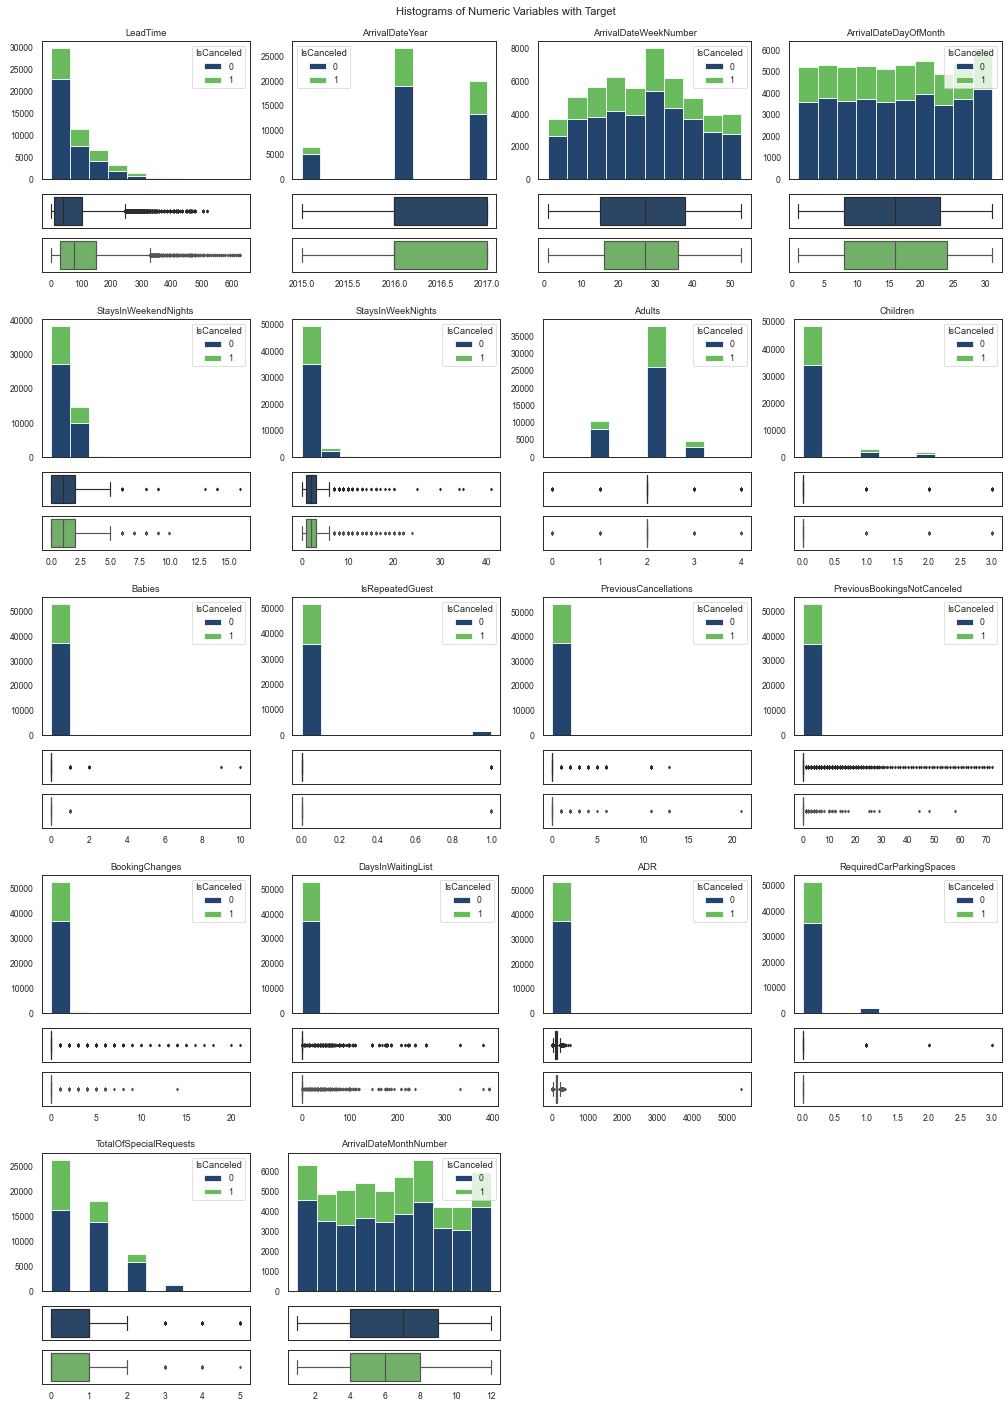

In [84]:
plot_histograms_boxplots_target(df, num_feats, 'IsCanceled', rows=5)

In [85]:
#plot_histograms_boxplots_target(df_hasdups, num_feats, 'IsCanceled', rows=5)

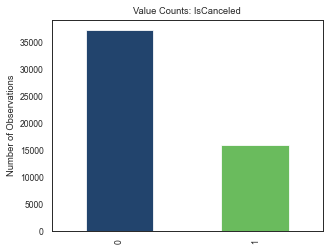

In [86]:
fig, ax = plt.subplots(figsize=(5,4))
df.groupby(['IsCanceled']).size()\
        .plot(kind="bar", stacked=False, color=CAT_COLORS[0:2])
ax.set_xlabel(None)
ax.set_ylabel('Number of Observations')
ax.set_title('Value Counts: IsCanceled')
plt.show()

In [87]:
## Function to plot histograms of cat features for specified dataframe
def plot_cat_counts(df, features, target, rows=6, title = "Count Distributions of Categorical Variables"):
    if show_plots:
        fig = plt.figure(figsize=(2.85*rows, 4*rows), constrained_layout=True)
        subfigs = fig.subfigures(rows, ceil(len(features) / rows), wspace=0.07, hspace=0.1)
        c = CAT_COLORS[0:2]
        for subf, feat in zip(subfigs.flatten(), features):
            axs = subf.subplots(1, 2, sharey=True) #, gridspec_kw={'width_ratios': [4, 1,1]})
 
            df1 = df.groupby([feat,target]).size().unstack(1)\
                .plot(kind="barh", stacked=True, ax=axs[0], color=c)

            df2 = df.groupby([feat,target]).size().unstack(1)
            df2.div(df2.sum(axis=1), axis=0)\
                .plot(kind="barh", stacked=True, ax=axs[1], color=c)
            
            subf.suptitle(feat)
            

        plt.suptitle(title)
        plt.show()
        if SAVE_PLOTS:
            save_fig(title, fig)

    else:
        print("show_plots is currently set to False")

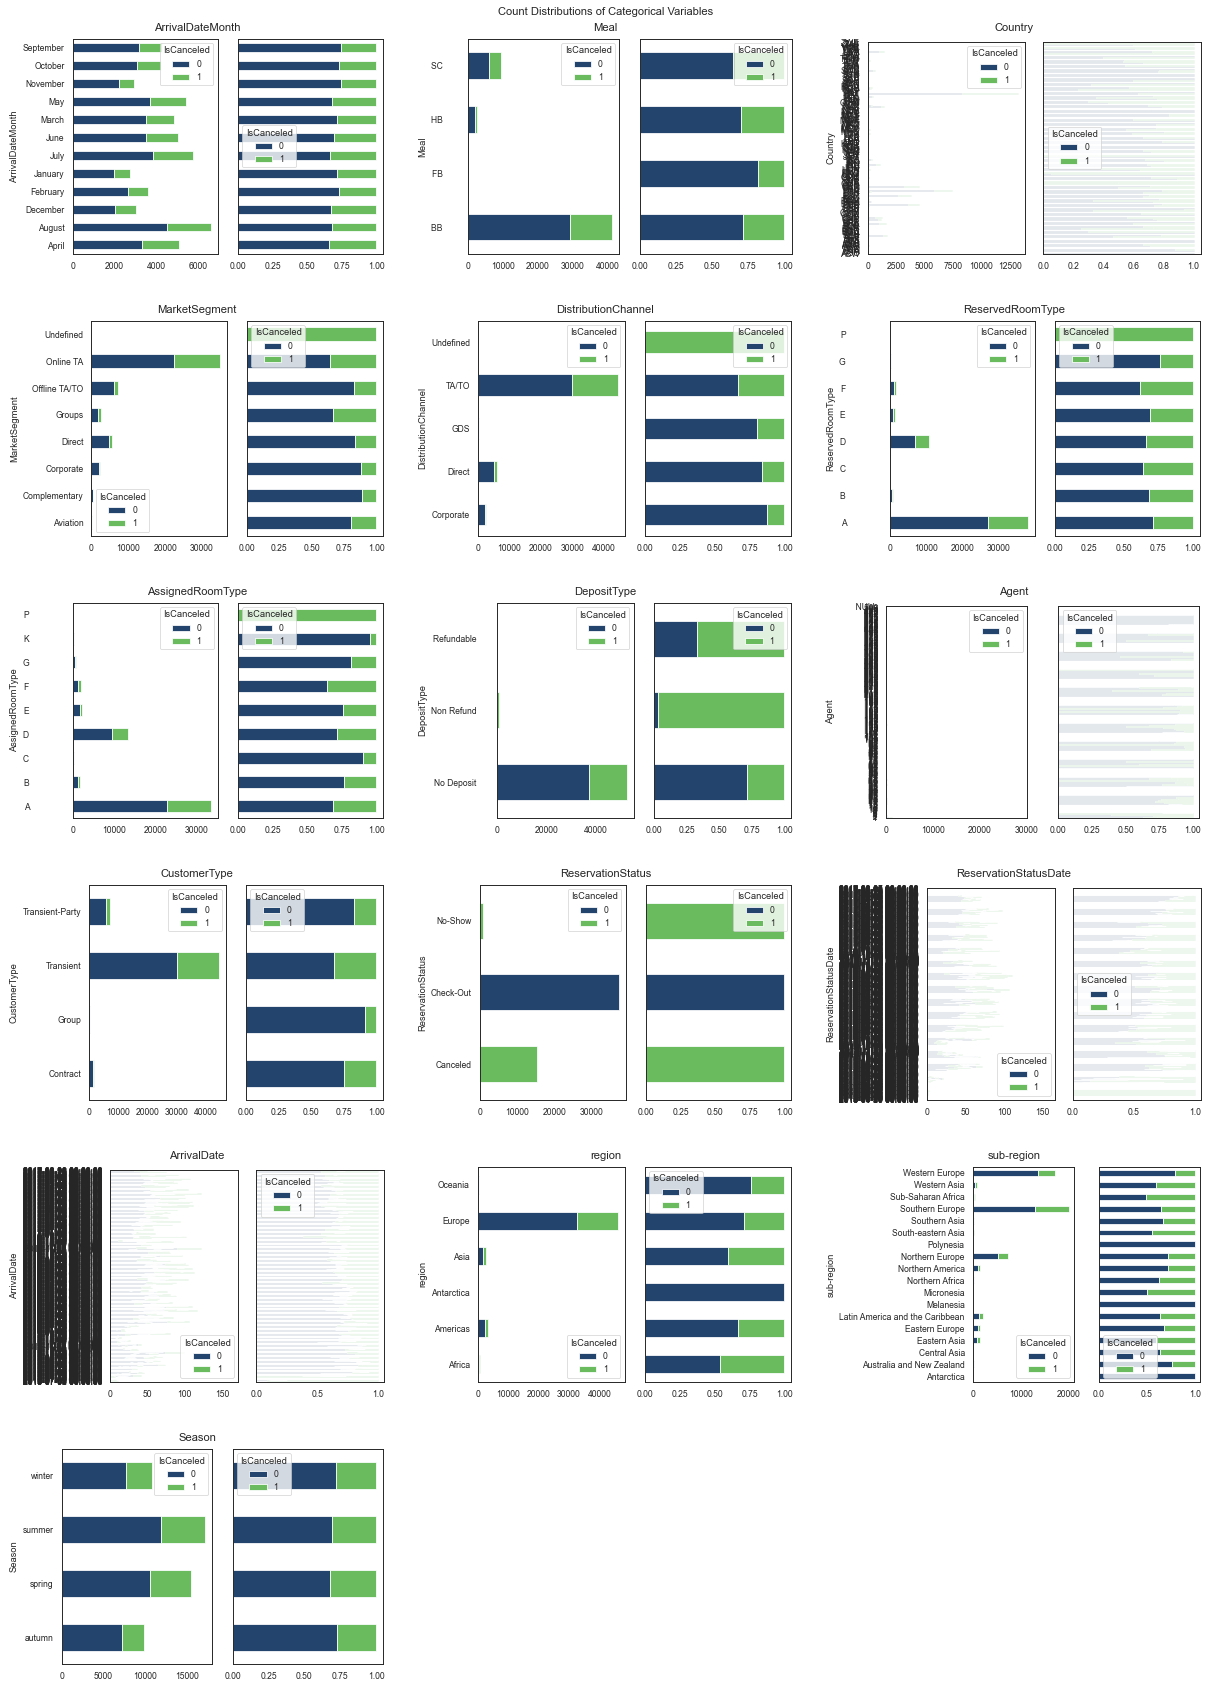

In [88]:
plot_cat_counts(df, cat_feats, 'IsCanceled', rows = 6)

In [89]:
# plot_cat_counts(df_hasdups, cat_feats, 'IsCanceled', rows = 6)

In [90]:
# aggregated and shape data

def show_barplot_compare(df, g1, g2) :
    if show_plots:
        
        df = df.sort_values(by=g2,ascending=False)
    
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(23,23))
 
        df1 = df.groupby([g1,g2]).size().unstack(1)\
                .plot(kind="barh", stacked=True, ax=ax[0], color=CONTRAST_COLORS)

        # aggregated and shape data
        df2 = df.groupby([g1,g2]).size().unstack(1)
        df2.div(df2.sum(axis=1), axis=0)\
                .plot(kind="barh", stacked=True, ax=ax[1], color=CONTRAST_COLORS)
    
        plt.show()
        if SAVE_PLOTS:
            save_fig('Bar plot '+ g1 + ' ' + g2, fig)
            

In [91]:
def absolute_relative_histoplot(df, feat, target, title='Absolute and Relative Distributions of Canceled Status by Country', figsize=(21,28)):
    df_ar = df.groupby([feat,target]).size().unstack()
    df_ar = df_ar.T.reset_index(drop=True).T.replace(np.nan,0)
    df_ar['total'] = df_ar[0]+df_ar[1]
    df_ar.sort_values(by='total', inplace=True)


    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=figsize, sharey=True)
    df_ar[target] = df_ar[1]
    not_t = 'Not ' + target
    df_ar[not_t] = df_ar[0]

    df_ar.loc[:,[not_t, target]]\
                     .plot(kind="barh", width=1, stacked=True, ax=ax[1], color=CAT_COLORS)
    ax[1].legend(bbox_to_anchor=(.6,1,.4,1), loc="lower left", frameon=False,
                            mode='expand', borderaxespad=0, ncol=2)
    ax[1].set_title('Absolute Distribution', loc='left', fontsize=18)


    df_cc2 = df_ar.loc[:,[not_t, target]].div(df_ar['total'], axis=0)\
                    .plot(kind="barh", width=1, stacked=True, ax=ax[0], color=CAT_COLORS)
    ax[0].legend(bbox_to_anchor=(.6,1,.4,1), loc="lower left", frameon=False,
                            mode='expand', borderaxespad=0, ncol=2)
    ax[0].set_title('Relative Distribution', loc='left', fontsize=18)

    
    ax[0].yaxis.set_label_position("right")
    ax[0].yaxis.tick_right()
    ax[0].set_ylabel(None)
    ax[1].set_ylabel(None)

    
    fig.suptitle(title, fontsize=24)
    plt.tight_layout()
    plt.show()
    

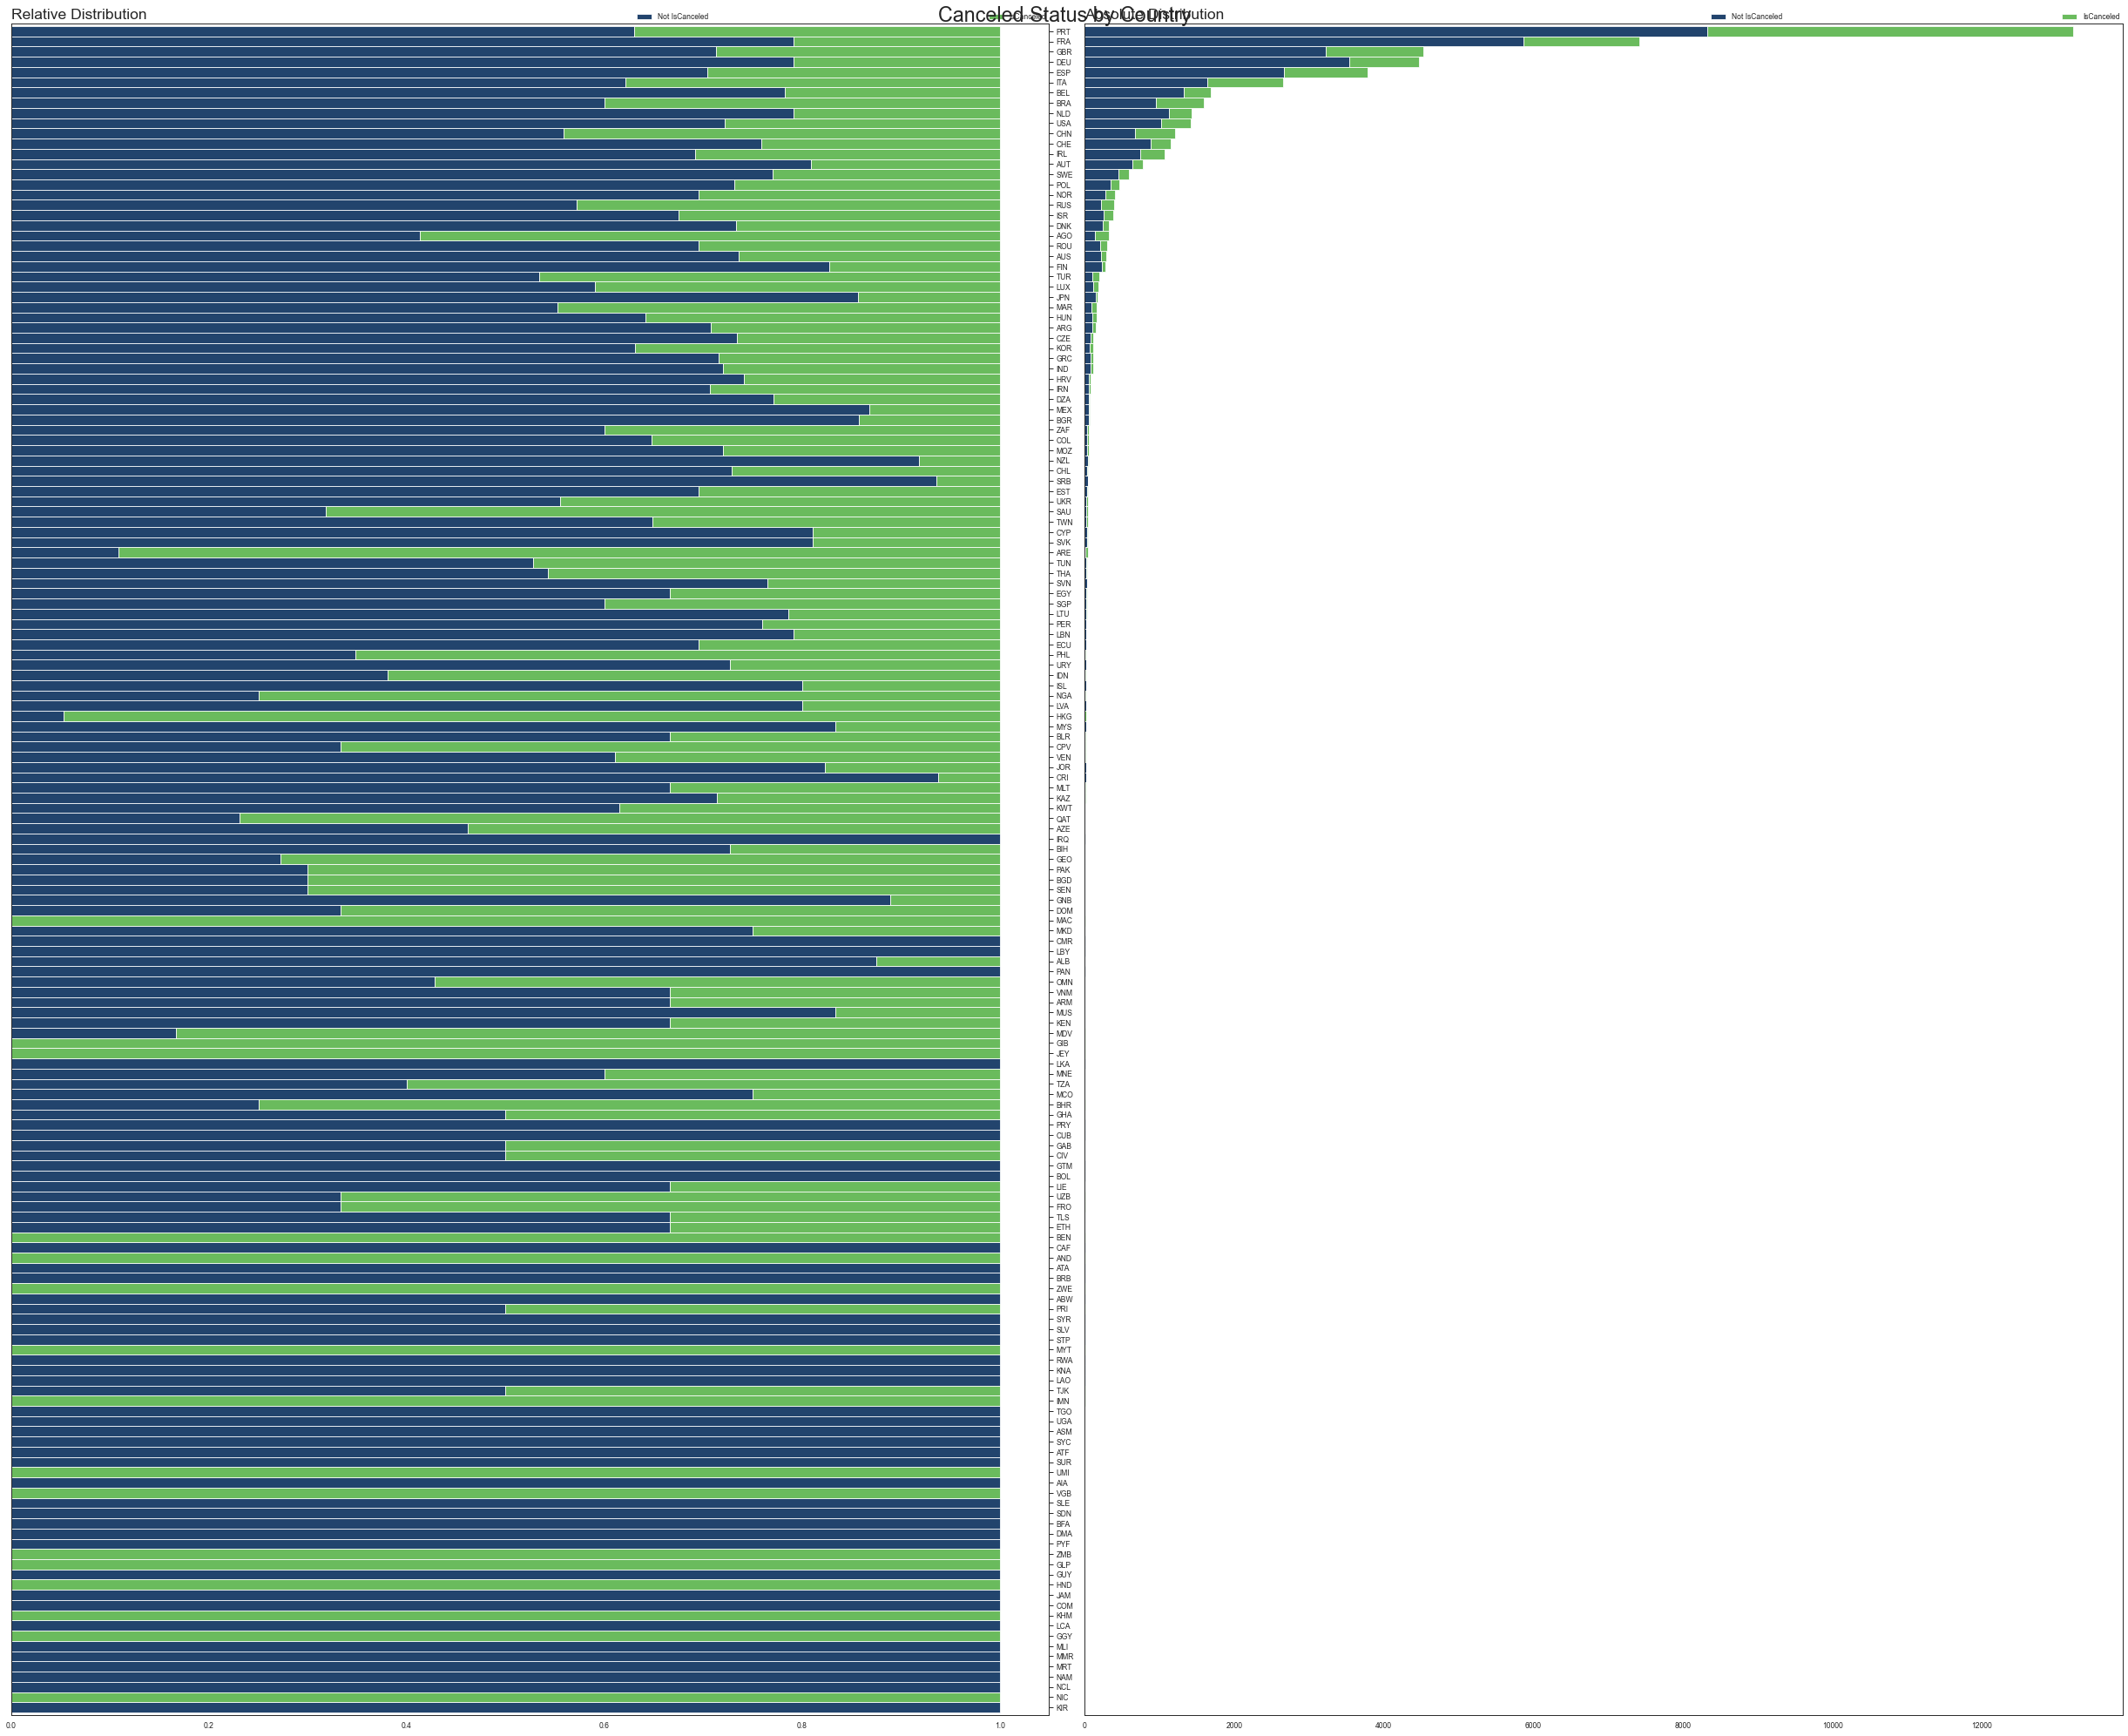

In [92]:
absolute_relative_histoplot(df, 'Country', 'IsCanceled', title='Canceled Status by Country', figsize=(35,29))


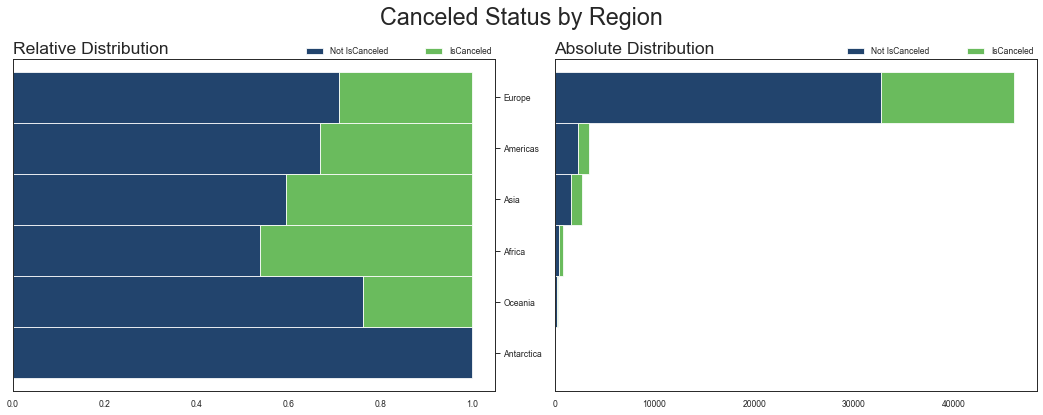

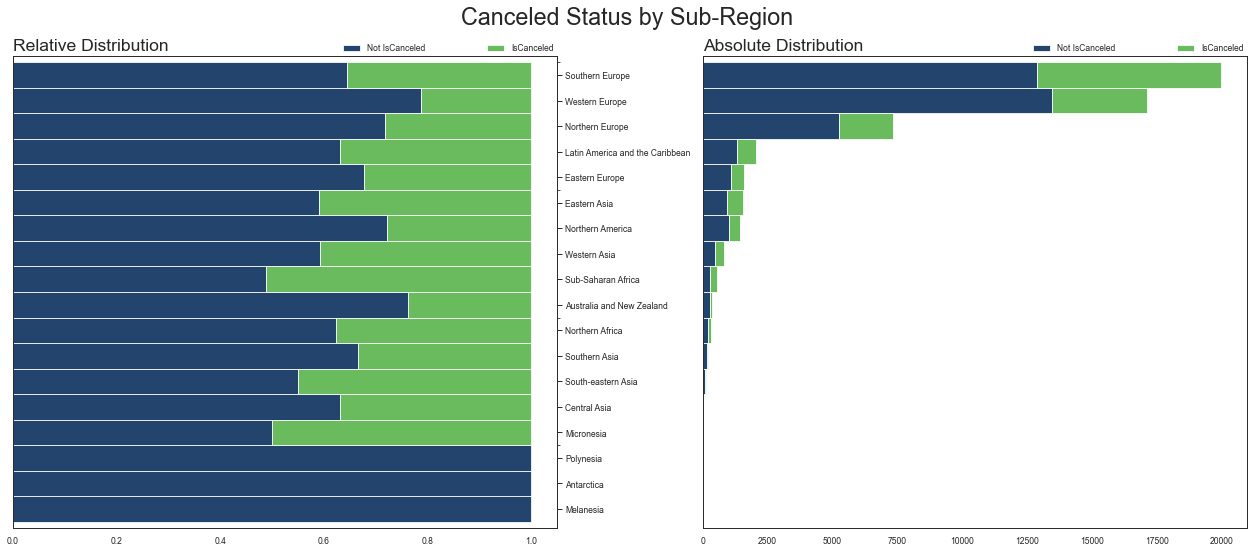

In [93]:
absolute_relative_histoplot(df, 'region', 'IsCanceled', title='Canceled Status by Region', figsize=(15,6))
absolute_relative_histoplot(df, 'sub-region', 'IsCanceled', title='Canceled Status by Sub-Region', figsize=(18,8))


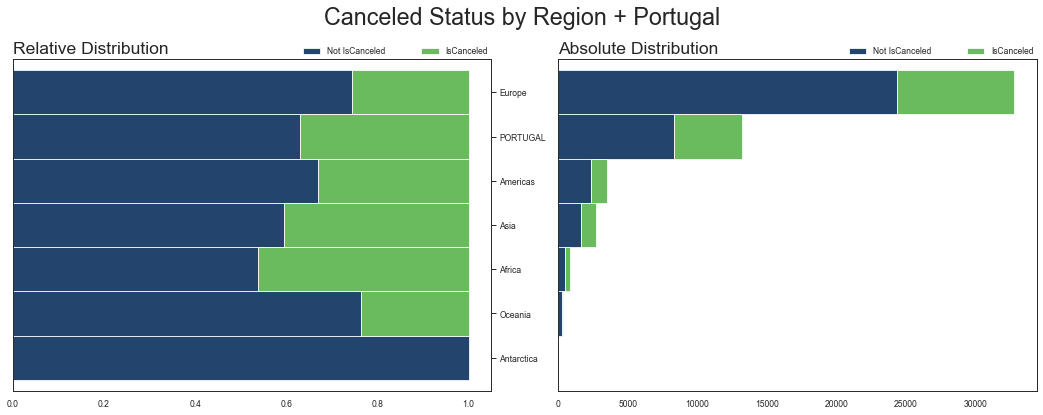

In [94]:
df['region alt'] = df['region']
df.loc[df['Country']=='PRT',['region alt']] = 'PORTUGAL'
absolute_relative_histoplot(df, 'region alt', 'IsCanceled', title='Canceled Status by Region + Portugal', figsize=(15,6))


## Feature Selection - extra preprocessing

In [227]:
df

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,...,ArrivalDateMonthNumber,ArrivalDate,region,sub-region,Season,PctCanceledPrevWeek,region alt,RSday,RSmonth,RSyear
0,0,6,2015,July,27,1,0,2,1,0.0,...,7,2015-07-01,Europe,Southern Europe,summer,0.500000,PORTUGAL,3,7,2015
1,1,88,2015,July,27,1,0,4,2,0.0,...,7,2015-07-01,Europe,Southern Europe,summer,0.500000,PORTUGAL,1,7,2015
2,1,65,2015,July,27,1,0,4,1,0.0,...,7,2015-07-01,Europe,Southern Europe,summer,0.500000,PORTUGAL,30,4,2015
3,1,92,2015,July,27,1,2,4,2,0.0,...,7,2015-07-01,Europe,Southern Europe,summer,0.500000,PORTUGAL,23,6,2015
4,1,100,2015,July,27,2,0,2,2,0.0,...,7,2015-07-02,Europe,Southern Europe,summer,0.500000,PORTUGAL,2,4,2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53421,0,23,2017,August,35,30,2,5,2,0.0,...,8,2017-08-30,Europe,Western Europe,summer,0.312500,Europe,6,9,2017
53422,0,102,2017,August,35,31,2,5,3,0.0,...,8,2017-08-31,Europe,Western Europe,summer,0.333333,Europe,7,9,2017
53423,0,34,2017,August,35,31,2,5,2,0.0,...,8,2017-08-31,Europe,Western Europe,summer,0.333333,Europe,7,9,2017
53424,0,109,2017,August,35,31,2,5,2,0.0,...,8,2017-08-31,Europe,Northern Europe,summer,0.333333,Europe,7,9,2017


In [228]:
df['RSday'] = df['ReservationStatusDate'].dt.day
df['RSmonth'] = df['ReservationStatusDate'].dt.month
df['RSyear'] = df['ReservationStatusDate'].dt.year


X = df.loc[:, df.columns != 'IsCanceled']
X.drop('ReservationStatus', 1, inplace=True)
X.drop('ReservationStatusDate', 1, inplace=True)
X.drop('ArrivalDate', 1, inplace=True)
X.drop('ArrivalDateMonth', 1, inplace=True)

X.drop('sub-region', 1, inplace=True)
X.drop('region', 1, inplace=True)

X.drop('Agent', 1, inplace=True) 
X.drop('Country', 1, inplace=True)

y = df['IsCanceled']
X_train, X_val, y_train, y_val = train_test_split(X,y, test_size = 0.3,
                                                  random_state = 9, stratify = y, shuffle = True)

## Feature selection for categorical data

In [229]:
def TestIndependence(X,y,var,alpha=0.05):        
    dfObserved = pd.crosstab(y,X) 
    chi2, p, dof, expected = stats.chi2_contingency(dfObserved.values)
    dfExpected = pd.DataFrame(expected, columns=dfObserved.columns, index = dfObserved.index)
    if p<alpha:
        result="{0} is IMPORTANT for Prediction".format(var)
    else:
        result="{0} is NOT an important predictor. (Discard {0} from model)".format(var)
    print(result)

In [230]:
#categorical_features = ['ArrivalDateYear','ArrivalDateWeekNumber','ArrivalDateDayOfMonth','Meal','region','sub-region','Season','region alt','RSday','RSmonth','RSyear']

#categorical_features=['Meal','MarketSegment','DistributionChannel','ReservedRoomType','AssignedRoomType','DepositType','CustomerType','Season','region alt']
#numeric_features=['LeadTime','StaysInWeekendNights','StaysInWeekNights','Adults','Children','Babies','TotalOfSpecialRequests']

#X_train_cat=X_train[categorical_features]
#X_train_num=X_train[numeric_features]
#X_val_cat=X_val[categorical_features]
#X_val_num=X_val[numeric_features]


#train
X_train_num = X_train.select_dtypes(include=np.number).set_index(X_train.index)
X_train_cat = X_train.select_dtypes(exclude=np.number).set_index(X_train.index)
# validation
X_val_num = X_val.select_dtypes(include=np.number).set_index(X_val.index)
X_val_cat = X_val.select_dtypes(exclude=np.number).set_index(X_val.index)

In [231]:
for var in X_train[categorical_features]:
    TestIndependence(X_train_cat[var],y_train, var)

Meal is IMPORTANT for Prediction
MarketSegment is IMPORTANT for Prediction
DistributionChannel is IMPORTANT for Prediction
ReservedRoomType is IMPORTANT for Prediction
AssignedRoomType is IMPORTANT for Prediction
DepositType is IMPORTANT for Prediction
CustomerType is IMPORTANT for Prediction
Season is IMPORTANT for Prediction
region alt is IMPORTANT for Prediction


## Filter Methods

In [232]:
X_train_num.var()

LeadTime                       6753.610852
ArrivalDateYear                   0.434446
ArrivalDateWeekNumber           183.863059
ArrivalDateDayOfMonth            77.704918
StaysInWeekendNights              0.835280
StaysInWeekNights                 2.627637
Adults                            0.294968
Children                          0.194046
Babies                            0.009841
IsRepeatedGuest                   0.031209
PreviousCancellations             0.143844
PreviousBookingsNotCanceled       3.666945
BookingChanges                    0.497218
DaysInWaitingList               137.504914
ADR                            1777.728303
RequiredCarParkingSpaces          0.033320
TotalOfSpecialRequests            0.690021
ArrivalDateMonthNumber            9.408037
PctCanceledPrevWeek               0.009480
RSday                            76.632035
RSmonth                          10.290132
RSyear                            0.426637
dtype: float64

In [233]:
all_train_num = X_train_num.join(y_train)
all_train_num.head()

,LeadTime,ArrivalDateYear,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,IsRepeatedGuest,...,DaysInWaitingList,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ArrivalDateMonthNumber,PctCanceledPrevWeek,RSday,RSmonth,RSyear,IsCanceled
17602,77,2017,30,25,0,4,2,0.0,0,0,...,0,106.60,0,0,7,0.292683,18,7,2017,1
11897,199,2016,53,29,0,3,2,0.0,0,0,...,0,107.10,0,0,12,0.454545,29,12,2016,1
33880,126,2016,35,24,0,3,2,0.0,0,0,...,0,121.13,1,0,8,0.372340,27,8,2016,0
52517,73,2017,33,14,1,3,3,0.0,0,0,...,0,200.00,0,0,8,0.312500,18,8,2017,0
45410,53,2017,15,13,1,3,2,0.0,0,0,...,0,139.50,0,1,4,0.344444,17,4,2017,0


In [234]:
def cor_heatmap(cor):
    plt.figure(figsize=(12,10))
    sns.heatmap(data = cor, annot = True, cmap = plt.cm.Reds, fmt='.1')
    plt.show()
    
cor_spearman = all_train_num.corr(method ='spearman')
cor_spearman

,LeadTime,ArrivalDateYear,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,IsRepeatedGuest,...,DaysInWaitingList,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ArrivalDateMonthNumber,PctCanceledPrevWeek,RSday,RSmonth,RSyear,IsCanceled
LeadTime,1.000000,0.180261,0.075574,0.024650,0.163455,0.289114,0.225844,0.051271,-0.022447,-0.216548,...,0.116796,0.025454,-0.067908,0.036883,0.078340,0.183473,0.003496,0.019744,0.127415,0.214924
ArrivalDateYear,0.180261,1.000000,-0.508515,-0.017680,0.028159,0.048908,0.090693,0.032368,-0.019699,-0.009415,...,-0.054077,0.248403,-0.030291,0.065888,-0.491523,0.399041,-0.010053,-0.395235,0.950320,0.078775
ArrivalDateWeekNumber,0.075574,-0.508515,1.000000,0.092219,0.004411,-0.000113,-0.001345,0.016898,0.015717,-0.006744,...,0.001426,0.075042,0.005980,0.044865,0.995267,-0.048375,0.038375,0.799848,-0.452303,-0.011402
ArrivalDateDayOfMonth,0.024650,-0.017680,0.092219,1.000000,-0.002880,-0.008359,0.001045,0.012389,0.000491,-0.014733,...,0.014217,0.019539,0.005456,-0.009561,0.003920,-0.032106,0.369027,-0.001176,0.005792,0.006233
StaysInWeekendNights,0.163455,0.028159,0.004411,-0.002880,1.000000,0.081258,0.107049,0.026568,0.004826,-0.107073,...,-0.050435,0.012174,-0.052652,0.023378,0.001711,0.034652,0.012901,-0.005793,0.024665,0.048951
StaysInWeekNights,0.289114,0.048908,-0.000113,-0.008359,0.081258,1.000000,0.152722,0.028043,-0.001282,-0.147192,...,0.006102,0.034828,-0.056863,0.054976,0.001738,-0.007842,-0.018674,-0.031272,0.043952,0.093870
Adults,0.225844,0.090693,-0.001345,0.001045,0.107049,0.152722,1.000000,0.022421,0.017127,-0.217111,...,-0.045199,0.337235,0.002162,0.153735,0.000459,0.101346,-0.004779,-0.027802,0.085818,0.090318
Children,0.051271,0.032368,0.016898,0.012389,0.026568,0.028043,0.022421,1.000000,0.025449,-0.043458,...,-0.032782,0.271531,0.034711,0.083748,0.016215,0.044116,0.006654,0.010529,0.026595,0.037090
Babies,-0.022447,-0.019699,0.015717,0.000491,0.004826,-0.001282,0.017127,0.025449,1.000000,-0.006119,...,-0.007102,0.002062,0.016213,0.075773,0.015554,-0.010576,-0.013579,0.013908,-0.014899,-0.024481
IsRepeatedGuest,-0.216548,-0.009415,-0.006744,-0.014733,-0.107073,-0.147192,-0.217111,-0.043458,-0.006119,1.000000,...,-0.016342,-0.196515,0.094734,0.004168,-0.006251,-0.041268,-0.012947,0.009714,-0.003736,-0.075700


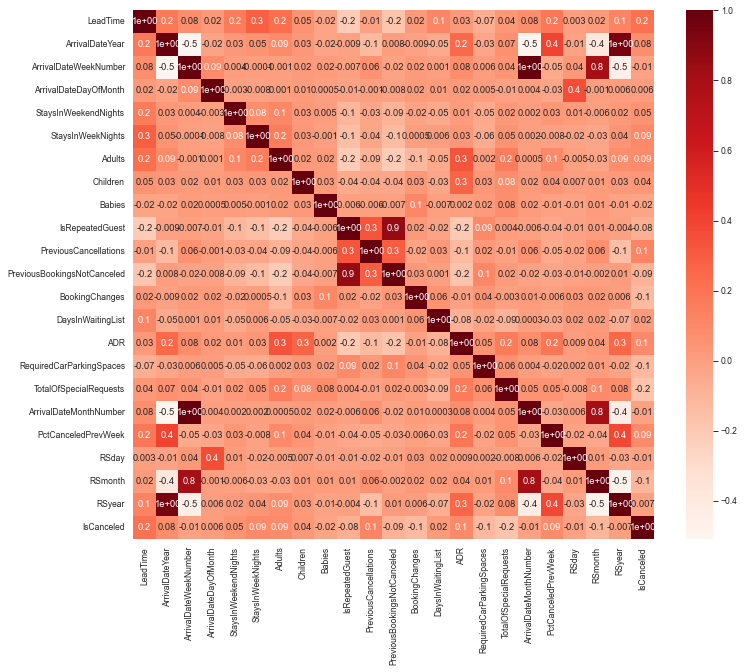

In [235]:
cor_heatmap(cor_spearman)

## Embedded Methods

In [236]:
def plot_importance(coef,name):
    imp_coef = coef.sort_values()
    plt.figure(figsize=(8,10))
    imp_coef.plot(kind = "barh")
    plt.title("Feature importance using " + name + " Model")
    plt.show()
    
reg = LassoCV()
reg.fit(X_train_num, y_train)
coef = pd.Series(reg.coef_, index = X_train_num.columns)
coef

LeadTime                       0.000333
ArrivalDateYear                0.970684
ArrivalDateWeekNumber          0.020873
ArrivalDateDayOfMonth         -0.000181
StaysInWeekendNights           0.005201
StaysInWeekNights              0.018607
Adults                         0.000000
Children                      -0.000000
Babies                        -0.000000
IsRepeatedGuest               -0.000000
PreviousCancellations          0.007668
PreviousBookingsNotCanceled   -0.001820
BookingChanges                -0.034972
DaysInWaitingList             -0.000343
ADR                            0.001163
RequiredCarParkingSpaces      -0.015135
TotalOfSpecialRequests        -0.062711
ArrivalDateMonthNumber         0.000000
PctCanceledPrevWeek            0.000000
RSday                         -0.003050
RSmonth                       -0.099531
RSyear                        -0.982399
dtype: float64

<AxesSubplot:xlabel='Value', ylabel='Col'>

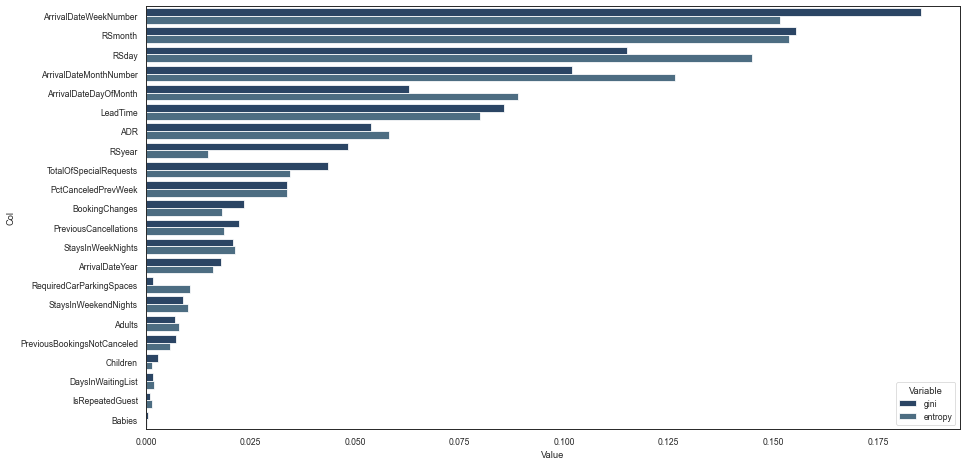

In [237]:
gini_importance = DecisionTreeClassifier().fit(X_train_num, y_train).feature_importances_
entropy_importance = DecisionTreeClassifier(criterion='entropy').fit(X_train_num, y_train).feature_importances_

import seaborn as sns

zippy = pd.DataFrame(zip(gini_importance, entropy_importance), columns = ['gini','entropy'])
zippy['col'] = X_train_num.columns
tidy = zippy.melt(id_vars='col').rename(columns=str.title)
tidy.sort_values(['Value'], ascending = False, inplace = True)

plt.figure(figsize=(15,8))
sns.barplot(y='Col', x='Value', hue='Variable', data=tidy)

In [238]:
##REMOVE BABBIES from train and val
X_train.drop('Babies', axis = 1, inplace = True)
X_val.drop('Babies', axis = 1, inplace = True)
X.drop('Babies', axis = 1, inplace = True)

##REMOVE children from train and val
X_train.drop('Children', axis = 1, inplace = True)
X_val.drop('Children', axis = 1, inplace = True)
X.drop('Children', axis = 1, inplace = True)

In [ ]:
#I DID NOT REMOVE THE OUTLIERS AS THEY DONT USUALLY AFFECT TREES AND FORESTS
#I DID NOT USE SCALER AS IT DOESNT USUALLY AFFECT TREES

In [242]:
#ONE HOT ENCODING

#categorical data
categorical_cols = X_train_cat.columns 
categorical_cols2 = X_val_cat.columns 

#import pandas as pd
X_train= pd.get_dummies(X_train, columns = categorical_cols)
X_val= pd.get_dummies(X_val, columns = categorical_cols2)
X= pd.get_dummies(X, columns = categorical_cols2)

# DECISION TREE

In [302]:
def avg_score(model, data_to_slice, y_to_slice, columns_to_use):
    # apply kfold
    skf = RepeatedStratifiedKFold(n_splits=10, n_repeats=10)
    # create lists to store the results from the different models 
    score_train = []
    score_test = []
    f1_list = []

    for train_index, test_index in skf.split(data_to_slice[columns_to_use],y_to_slice):
        # get the indexes of the observations assigned for each partition
        X_train, X_val = data_to_slice[columns_to_use].iloc[train_index], data_to_slice[columns_to_use].iloc[test_index]
        y_train, y_val = y_to_slice.iloc[train_index], y.iloc[test_index]
        
        # applies the model 
        model_fit = model.fit(X_train, y_train)
        # predicts training 
        y_pred_train =  model_fit.predict(X_train)
        #predicts validation 
        y_pred_val = model_fit.predict(X_val)
        # prints metric results 
        
        #metrics(X_train, X_val, y_train, y_pred_train, y_val, y_pred_val, model)
        
        value_train = model.score(X_train, y_train)
        # check the mean accuracy for the test
        value_test = model.score(X_val,y_val)
        f1_score_val = f1_score(y_val, y_pred_val)
        # append the accuracies, the time and the number of iterations in the corresponding list
        score_train.append(value_train)
        score_test.append(value_test)
        f1_list.append(f1_score_val)
        
    avg_train = round(np.mean(score_train),3)
    avg_test = round(np.mean(score_test),3)
    std_train = round(np.std(score_train),2)
    std_test = round(np.std(score_test),2)
    avg_f1 = round(np.mean(f1_list),3)
    std_f1 = round(np.std(f1_list),2)
    return str(avg_train) + '+/-' + str(std_train),\
            str(avg_test) + '+/-' + str(std_test) , str(avg_f1) + '+/-' + str(std_f1), avg_f1

In [303]:
def avg_score2(model):
    # apply kfold
    skf = StratifiedKFold(n_splits=10)
    # create lists to store the results from the different models 
    score_train = []
    score_test = []
    timer = []
    for train_index, test_index in skf.split(X,y):
        # get the indexes of the observations assigned for each partition
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        # start counting time
        begin = time.perf_counter()
        # fit the model to the data
        model.fit(X_train, y_train)
        # finish counting time
        end = time.perf_counter()
        # check the mean accuracy for the train
        value_train = model.score(X_train, y_train)
        # check the mean accuracy for the test
        value_test = model.score(X_test,y_test)
        # append the accuracies, the time and the number of iterations in the corresponding list
        score_train.append(value_train)
        score_test.append(value_test)
        timer.append(end-begin)
    # calculate the average and the std for each measure (accuracy, time and number of iterations)
    avg_time = round(np.mean(timer),3)
    avg_train = round(np.mean(score_train),3)
    avg_test = round(np.mean(score_test),3)
    std_time = round(np.std(timer),2)
    std_train = round(np.std(score_train),2)
    std_test = round(np.std(score_test),2)
    
    return str(avg_time) + '+/-' + str(std_time), str(avg_train) + '+/-' + str(std_train),\
str(avg_test) + '+/-' + str(std_test)

In [ ]:
def show_results(df, *args):
    """
    Receive an empty dataframe and the different models and call the function avg_score
    """
    count = 0
    # for each model passed as argument
    for arg in args:
        # obtain the results provided by avg_score
        time, avg_train, avg_test = avg_score(arg)
        # store the results in the right row
        df.iloc[count] = time, avg_train, avg_test
        count+=1
    return df

In [ ]:
def metrics(X_train, X_val, y_train, pred_train , y_val, pred_val, model):
    print('___________________________________________________________________________________________________________')
    print('                                                     TRAIN                                                 ')
    print('-----------------------------------------------------------------------------------------------------------')
    print(classification_report(y_train, pred_train))
    print(confusion_matrix(y_train, pred_train))
    print("Score: "+ str(model.score(X_train, y_train)))
    print("F1 Score: "+ str(f1_score(y_train, pred_train)))

    print('___________________________________________________________________________________________________________')
    print('                                                VALIDATION                                                 ')
    print('-----------------------------------------------------------------------------------------------------------')
    print(classification_report(y_val, pred_val))
    print(confusion_matrix(y_val, pred_val))
    print("Score: "+ str(model.score(X_val, y_val)))
    print("F1 Score: "+ str(f1_score(y_val, pred_val)))
    
from sklearn.metrics import classification_report, confusion_matrix

In [249]:
#TESTING
from sklearn.metrics import accuracy_score

dt_gini = DecisionTreeClassifier().fit(X_train, y_train)

y_pred_val=dt_gini.predict(X_val)

print('Accuracy score:', accuracy_score(y_val,y_pred_val))
print('F1 score:', f1_score(y_val,y_pred_val))

Accuracy score: 0.9139996256784578
F1 score: 0.8575856190918952


In [251]:
avg_score(dt_gini,X,y,X.columns)

('1.0+/-0.0', '0.923+/-0.0', '0.871+/-0.01', 0.871)

In [257]:
from sklearn.model_selection import StratifiedKFold
import time

dt_entropy = DecisionTreeClassifier(criterion = 'entropy').fit(X_train, y_train)

splitcriteria = pd.DataFrame(columns = ['Time','Train','Test'], index = ['Gini','Entropy'])

show_results(splitcriteria,dt_gini, dt_entropy)

#CONCLUSION - ENTROPY

,Time,Train,Test
Gini,0.35+/-0.02,1.0+/-0.0,0.484+/-0.14
Entropy,0.348+/-0.01,1.0+/-0.0,0.505+/-0.12


In [260]:
dt_random = DecisionTreeClassifier(splitter = 'random').fit(X_train, y_train)

splitter = pd.DataFrame(columns = ['Time','Train','Test'], index = ['best','random'])

show_results(splitter,dt_entropy, dt_random)

#CONCLUSION - BEST

,Time,Train,Test
best,0.355+/-0.01,1.0+/-0.0,0.506+/-0.12
random,0.185+/-0.01,1.0+/-0.0,0.477+/-0.12


Maximum Score: 0.5663442940038684
>5 0.545 (0.012)
Maximum Score: 0.7577188521612787
>10 0.725 (0.023)
Maximum Score: 0.8923369221025966
>20 0.876 (0.010)
Maximum Score: 0.8950482715664902
>25 0.883 (0.007)
Maximum Score: 0.8951965065502183
>30 0.883 (0.007)
Maximum Score: 0.8967882756470221
>40 0.884 (0.007)
Maximum Score: 0.8967882756470221
>50 0.884 (0.007)
Maximum Score: 0.8967882756470221
>100 0.884 (0.007)


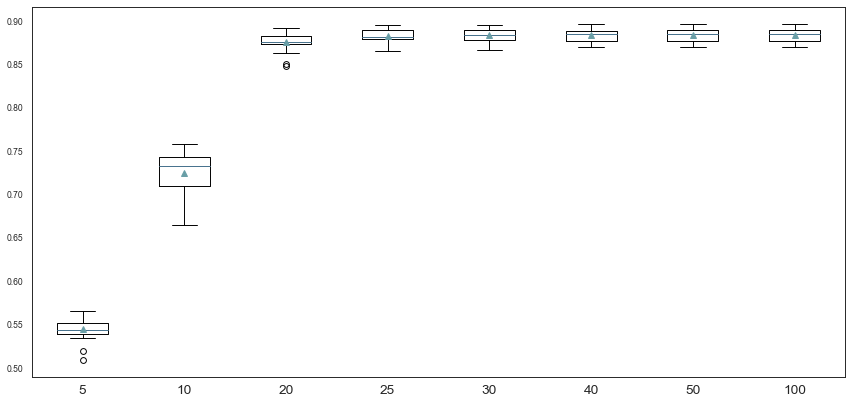

In [272]:
from sklearn.model_selection import cross_val_score
cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 1)

def return_f1score(model, X, y):
    n_scores = cross_val_score(model, X, y, scoring = 'f1', cv = cv)
    return n_scores

def return_results(models):
    results, names = [],[]
    for name, model in models.items():
        scores = return_f1score(model, X, y)
        print("Maximum Score: "+str(max(scores)))
        results.append(scores)
        names.append(name)
        print('>%s %.3f (%.3f)' % (name, scores.mean(), scores.std()))
    
    plt.figure(figsize=(15,7))
    plt.boxplot(results, labels = names, showmeans = True)
    plt.xticks(fontsize=14)
    plt.show()

def get_models(values):
    models = dict()
    for value in values:
        models[str(value)] = DecisionTreeClassifier(criterion='entropy', max_depth=value, random_state = 9)      
    return models

models = get_models([5,10,20,25,30,40,50,100])
return_results(models)

#Conclusion - 40 max depth

Maximum Score: nan
>1 nan (nan)
Maximum Score: 0.8967882756470221
>2 0.884 (0.007)
Maximum Score: 0.8958068614993646
>3 0.884 (0.007)
Maximum Score: 0.8972904851921865
>5 0.884 (0.006)
Maximum Score: 0.8930936613055819
>7 0.884 (0.006)
Maximum Score: 0.8958136606861821
>10 0.883 (0.006)
Maximum Score: 0.8946700507614213
>15 0.883 (0.007)
Maximum Score: 0.8924765902486276
>20 0.880 (0.007)
Maximum Score: 0.8854268094774425
>30 0.875 (0.007)
Maximum Score: 0.8788273615635178
>50 0.866 (0.007)


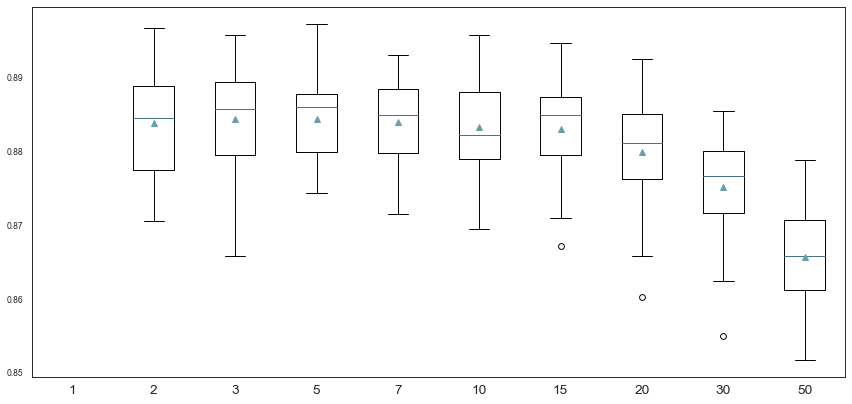

In [277]:
def get_models(values):
    models = dict()
    for value in values:
        models[str(value)] = DecisionTreeClassifier(criterion='entropy', max_depth=40, min_samples_split = value, splitter='best', random_state = 9)         
    return models

models = get_models([1,2,3,5,7,10,15,20,30,50])
return_results(models)

#conclusion min_samples_split= 5 

Maximum Score: 0.8987880773010154
>1000 0.887 (0.006)
Maximum Score: 0.9015374550212626
>1100 0.887 (0.006)
Maximum Score: 0.9051190088033909
>1200 0.888 (0.006)
Maximum Score: 0.9057337220602527
>1300 0.889 (0.007)
Maximum Score: 0.9059884095299421
>1500 0.889 (0.006)
Maximum Score: 0.9064609450337512
>1550 0.889 (0.006)
Maximum Score: 0.905357715752326
>1600 0.889 (0.006)
Maximum Score: 0.9051282051282051
>1650 0.889 (0.006)
Maximum Score: 0.9034526854219949
>1700 0.889 (0.006)


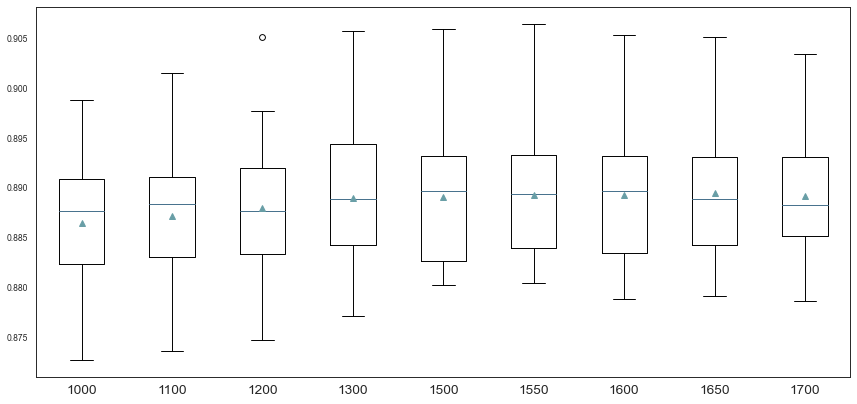

In [286]:
def get_models(values):
    models = dict()
    for value in values:
        models[str(value)] = DecisionTreeClassifier(criterion='entropy', max_depth=40, min_samples_split = 5, random_state = 9, splitter='best', max_leaf_nodes=value)                  
    return models

models = get_models([1000,1100,1200,1300,1500, 1550,1600,1650,1700])
return_results(models)

#conclusion max_leaf_nodes=1550

Maximum Score: 0.890630101207966
>50 0.868 (0.011)
Maximum Score: 0.9015078601219121
>60 0.882 (0.008)
Maximum Score: 0.9042690815006468
>70 0.889 (0.007)
Maximum Score: nan
>80 nan (nan)
Maximum Score: 0.9064609450337512
>None 0.889 (0.006)


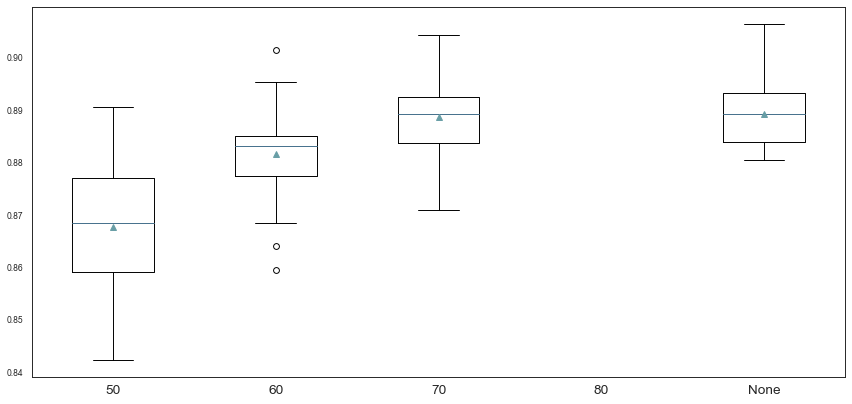

In [289]:
def get_models(values):
    models = dict()
    for value in values:
        models[str(value)] = DecisionTreeClassifier(criterion='entropy', max_depth=40, min_samples_split = 5, max_leaf_nodes=1550, random_state =9, splitter='best',max_features=value)        
    return models

models = get_models([50, 60, 70, 80, None])
return_results(models)

#conclusion - None

### Final result

In [294]:
#TESTING

dt_final = DecisionTreeClassifier(criterion='entropy', max_depth=40, min_samples_split = 5, max_leaf_nodes=1550, random_state =9, splitter='best',max_features=None).fit(X_train, y_train)

y_pred_val=dt_final.predict(X_val)

print('Accuracy score:', accuracy_score(y_val,y_pred_val))
print('F1 score:', f1_score(y_val,y_pred_val))

Accuracy score: 0.9362717574396406
F1 score: 0.8908478922904312


In [298]:
avg_score(dt_final, X, y, X.columns)

___________________________________________________________________________________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.99      0.99     33639
           1       0.99      0.94      0.96     14444

    accuracy                           0.98     48083
   macro avg       0.98      0.97      0.97     48083
weighted avg       0.98      0.98      0.98     48083

[[33465   174]
 [  845 13599]]
Score: 0.978807478734688
F1 Score: 0.9638870184640465
___________________________________________________________________________________________________________
                                                VALIDATION                                                 
------------------------------------------------

___________________________________________________________________________________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     33639
           1       0.99      0.94      0.96     14445

    accuracy                           0.98     48084
   macro avg       0.98      0.97      0.97     48084
weighted avg       0.98      0.98      0.98     48084

[[33453   186]
 [  886 13559]]
Score: 0.9777056817236502
F1 Score: 0.9619723306136927
___________________________________________________________________________________________________________
                                                VALIDATION                                                 
-----------------------------------------------

___________________________________________________________________________________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     33639
           1       0.99      0.94      0.97     14444

    accuracy                           0.98     48083
   macro avg       0.98      0.97      0.98     48083
weighted avg       0.98      0.98      0.98     48083

[[33505   134]
 [  802 13642]]
Score: 0.9805336605453071
F1 Score: 0.9668320340184267
___________________________________________________________________________________________________________
                                                VALIDATION                                                 
-----------------------------------------------

___________________________________________________________________________________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.99      0.98     33640
           1       0.98      0.94      0.96     14444

    accuracy                           0.98     48084
   macro avg       0.98      0.97      0.97     48084
weighted avg       0.98      0.98      0.98     48084

[[33423   217]
 [  812 13632]]
Score: 0.9785999500873471
F1 Score: 0.9636305800021207
___________________________________________________________________________________________________________
                                                VALIDATION                                                 
-----------------------------------------------

___________________________________________________________________________________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     33639
           1       0.98      0.94      0.96     14444

    accuracy                           0.98     48083
   macro avg       0.98      0.96      0.97     48083
weighted avg       0.98      0.98      0.98     48083

[[33409   230]
 [  924 13520]]
Score: 0.9759998336210303
F1 Score: 0.9590693055259985
___________________________________________________________________________________________________________
                                                VALIDATION                                                 
-----------------------------------------------

___________________________________________________________________________________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     33639
           1       0.99      0.92      0.95     14444

    accuracy                           0.97     48083
   macro avg       0.98      0.96      0.97     48083
weighted avg       0.97      0.97      0.97     48083

[[33473   166]
 [ 1187 13257]]
Score: 0.9718611567497868
F1 Score: 0.9514479491872108
___________________________________________________________________________________________________________
                                                VALIDATION                                                 
-----------------------------------------------

___________________________________________________________________________________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.99      0.98     33639
           1       0.99      0.94      0.96     14445

    accuracy                           0.98     48084
   macro avg       0.98      0.97      0.97     48084
weighted avg       0.98      0.98      0.98     48084

[[33438   201]
 [  850 13595]]
Score: 0.9781424174361534
F1 Score: 0.9627846039446196
___________________________________________________________________________________________________________
                                                VALIDATION                                                 
-----------------------------------------------

___________________________________________________________________________________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     33639
           1       0.99      0.94      0.96     14444

    accuracy                           0.98     48083
   macro avg       0.98      0.97      0.97     48083
weighted avg       0.98      0.98      0.98     48083

[[33471   168]
 [  933 13511]]
Score: 0.977102094295281
F1 Score: 0.9608505493723998
___________________________________________________________________________________________________________
                                                VALIDATION                                                 
------------------------------------------------

___________________________________________________________________________________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     33640
           1       0.99      0.93      0.96     14444

    accuracy                           0.98     48084
   macro avg       0.98      0.96      0.97     48084
weighted avg       0.98      0.98      0.98     48084

[[33456   184]
 [  976 13468]]
Score: 0.9758755511188753
F1 Score: 0.9587129840546696
___________________________________________________________________________________________________________
                                                VALIDATION                                                 
-----------------------------------------------

___________________________________________________________________________________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      1.00      0.99     33639
           1       0.99      0.94      0.96     14444

    accuracy                           0.98     48083
   macro avg       0.98      0.97      0.97     48083
weighted avg       0.98      0.98      0.98     48083

[[33485   154]
 [  865 13579]]
Score: 0.978807478734688
F1 Score: 0.9638357525641481
___________________________________________________________________________________________________________
                                                VALIDATION                                                 
------------------------------------------------

___________________________________________________________________________________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     33639
           1       0.99      0.94      0.96     14444

    accuracy                           0.98     48083
   macro avg       0.98      0.97      0.97     48083
weighted avg       0.98      0.98      0.98     48083

[[33481   158]
 [  845 13599]]
Score: 0.9791402366740843
F1 Score: 0.9644338853232155
___________________________________________________________________________________________________________
                                                VALIDATION                                                 
-----------------------------------------------

___________________________________________________________________________________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.99      0.98     33639
           1       0.98      0.94      0.96     14445

    accuracy                           0.98     48084
   macro avg       0.98      0.97      0.97     48084
weighted avg       0.98      0.98      0.98     48084

[[33431   208]
 [  811 13634]]
Score: 0.9788079194742534
F1 Score: 0.9639763849117969
___________________________________________________________________________________________________________
                                                VALIDATION                                                 
-----------------------------------------------

___________________________________________________________________________________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     33639
           1       0.98      0.93      0.96     14444

    accuracy                           0.97     48083
   macro avg       0.98      0.96      0.97     48083
weighted avg       0.97      0.97      0.97     48083

[[33418   221]
 [  996 13448]]
Score: 0.9746895992346567
F1 Score: 0.9567104186675205
___________________________________________________________________________________________________________
                                                VALIDATION                                                 
-----------------------------------------------

___________________________________________________________________________________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.99      0.98     33640
           1       0.99      0.94      0.96     14444

    accuracy                           0.98     48084
   macro avg       0.98      0.97      0.97     48084
weighted avg       0.98      0.98      0.98     48084

[[33445   195]
 [  837 13607]]
Score: 0.9785375592712753
F1 Score: 0.9634638532889613
___________________________________________________________________________________________________________
                                                VALIDATION                                                 
-----------------------------------------------

___________________________________________________________________________________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     33639
           1       0.99      0.94      0.96     14444

    accuracy                           0.98     48083
   macro avg       0.98      0.97      0.98     48083
weighted avg       0.98      0.98      0.98     48083

[[33473   166]
 [  824 13620]]
Score: 0.979410602499844
F1 Score: 0.9649309245483527
___________________________________________________________________________________________________________
                                                VALIDATION                                                 
------------------------------------------------

___________________________________________________________________________________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     33639
           1       0.99      0.94      0.96     14444

    accuracy                           0.98     48083
   macro avg       0.98      0.97      0.97     48083
weighted avg       0.98      0.98      0.98     48083

[[33455   184]
 [  919 13525]]
Score: 0.9770604995528566
F1 Score: 0.9608212268674741
___________________________________________________________________________________________________________
                                                VALIDATION                                                 
-----------------------------------------------

___________________________________________________________________________________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     33639
           1       0.99      0.94      0.96     14445

    accuracy                           0.98     48084
   macro avg       0.98      0.97      0.97     48084
weighted avg       0.98      0.98      0.98     48084

[[33472   167]
 [  912 13533]]
Score: 0.9775601031528159
F1 Score: 0.9616628175519629
___________________________________________________________________________________________________________
                                                VALIDATION                                                 
-----------------------------------------------

('0.978+/-0.0', '0.936+/-0.0', '0.89+/-0.01', 0.89)

# Random Forest

In [316]:
#TESTING
from sklearn.ensemble import RandomForestClassifier

modelRFT = RandomForestClassifier().fit(X_train, y_train)

y_pred_val=modelRFT.predict(X_val)

print('Accuracy score:', accuracy_score(y_val,y_pred_val))
print('F1 score:', f1_score(y_val,y_pred_val))

Accuracy score: 0.9241063073179862
F1 score: 0.8608680734259735


Maximum Score: 0.880027266530334
>80 0.865 (0.008)
Maximum Score: 0.8810092055915446
>150 0.867 (0.007)
Maximum Score: 0.8809523809523809
>200 0.867 (0.007)
Maximum Score: 0.8800813008130082
>300 0.869 (0.006)
Maximum Score: 0.8816911012615071
>400 0.869 (0.007)


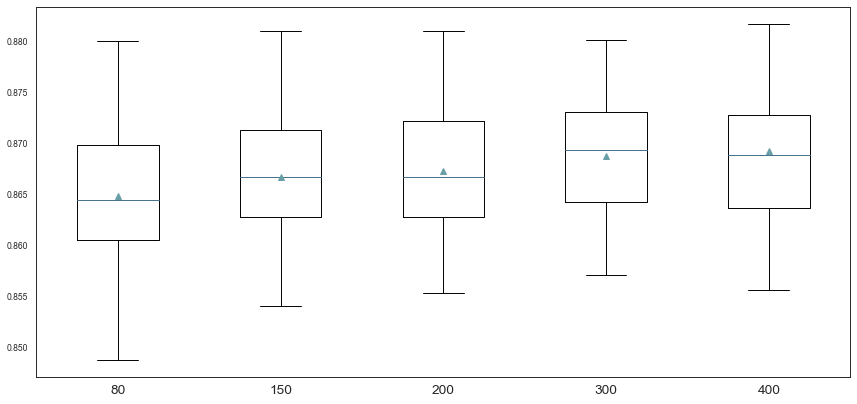

In [307]:
#n_estimators

def get_models(values):
    models = dict()
    for value in values:
        models[str(value)] = RandomForestClassifier(n_estimators = value, random_state = 9)      
    return models

models = get_models([80,150,200,300,400])
return_results(models)

Maximum Score: 0.8781153977466712
>100 0.866 (0.008)
Maximum Score: 0.8795345653661876
>110 0.866 (0.007)
Maximum Score: 0.879263301500682
>120 0.866 (0.007)


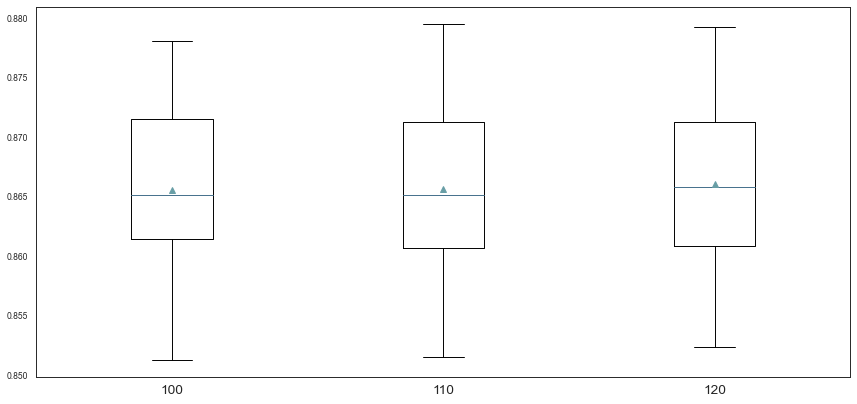

In [309]:
#n_estimators round 2

def get_models(values):
    models = dict()
    for value in values:
        models[str(value)] = RandomForestClassifier(n_estimators = value, random_state = 9)      
    return models

models = get_models([100,110,120])
return_results(models)

Maximum Score: 0.8781153977466712
>gini 0.866 (0.008)
Maximum Score: 0.8809201623815968
>entropy 0.866 (0.007)


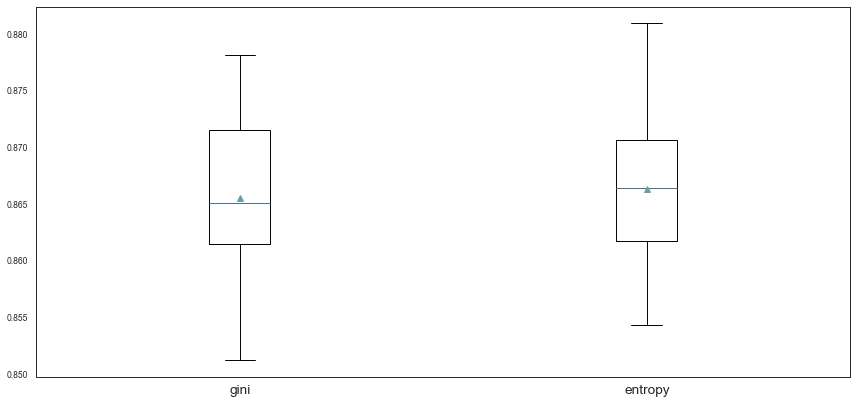

In [308]:
#CRITERION VALUE

def get_models(values):
    models = dict()
    for value in values:
        models[str(value)] = RandomForestClassifier(criterion = value, random_state = 9)      
    return models

models = get_models(['gini', 'entropy'])
return_results(models)

#Conclusion - Entropy

Maximum Score: 0.6682483194938711
>10 0.645 (0.011)
Maximum Score: 0.8330416520826042
>20 0.816 (0.007)
Maximum Score: 0.8781153977466712
>80 0.866 (0.008)
Maximum Score: 0.8781153977466712
>100 0.866 (0.008)


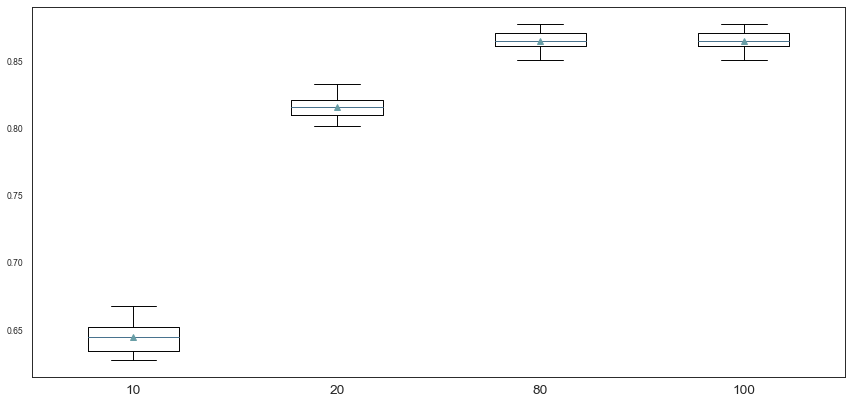

In [310]:
#max_depth

def get_models(values):
    models = dict()
    for value in values:
        models[str(value)] = RandomForestClassifier(max_depth = value, random_state = 9)      
    return models

models = get_models([10,20,80,100])
return_results(models)

Maximum Score: 0.876665527844209
>4 0.863 (0.007)
Maximum Score: 0.8750853242320819
>8 0.856 (0.008)
Maximum Score: 0.8493913043478262
>20 0.836 (0.007)


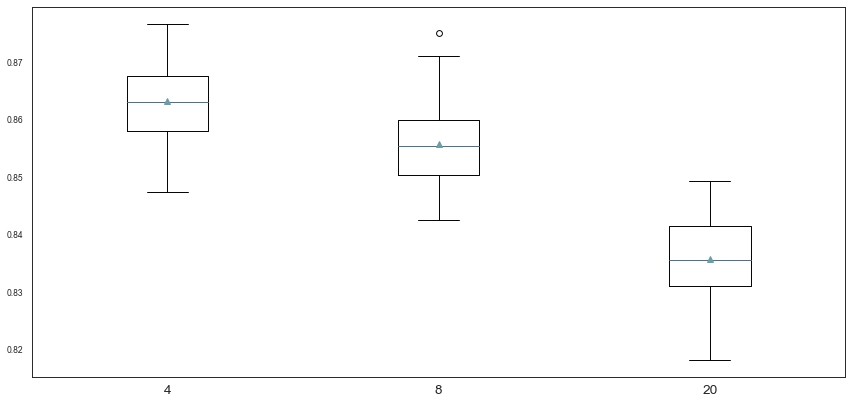

In [311]:
#min samples split 

def get_models(values):
    models = dict()
    for value in values:
        models[str(value)] = RandomForestClassifier(min_samples_split = value, random_state = 9)      
    return models

models = get_models([4,8,20])
return_results(models)

Maximum Score: 0.8637781629116119
>2 0.847 (0.008)
Maximum Score: 0.8434237995824635
>3 0.834 (0.006)
Maximum Score: 0.8336842105263157
>4 0.822 (0.006)


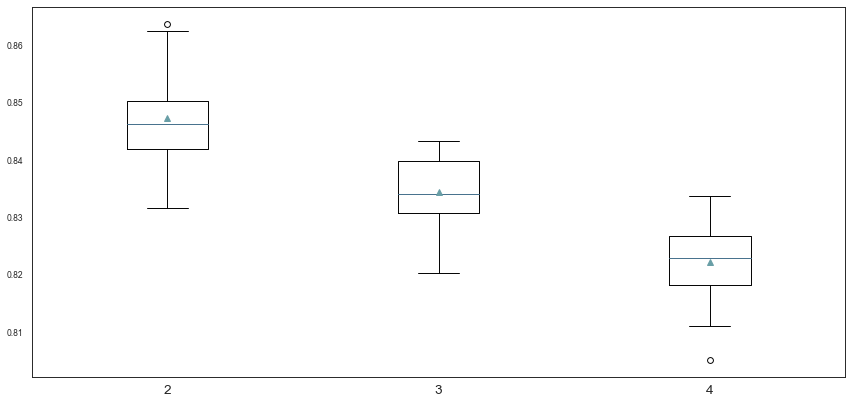

In [312]:
#min samples leaf

def get_models(values):
    models = dict()
    for value in values:
        models[str(value)] = RandomForestClassifier(min_samples_leaf = value, random_state = 9)      
    return models

models = get_models([2,3,4])
return_results(models)

Maximum Score: 0.8791509756932557
>balanced 0.864 (0.007)
Maximum Score: 0.8784473953013279
>balanced_subsample 0.863 (0.007)


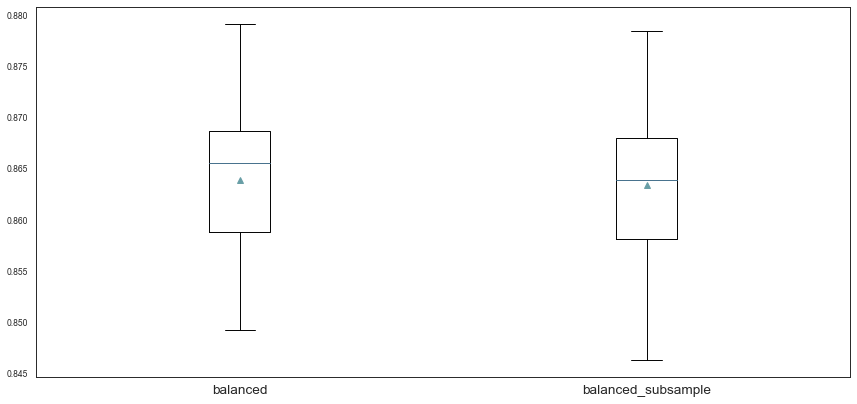

In [313]:
#class weight

def get_models(values):
    models = dict()
    for value in values:
        models[str(value)] = RandomForestClassifier(class_weight = value, random_state = 9)      
    return models

models = get_models(['balanced', 'balanced_subsample'])
return_results(models)

Maximum Score: 0.8781153977466712
>0 0.866 (0.008)
Maximum Score: 0.3563748079877112
>0.005 0.318 (0.022)
Maximum Score: 0.6974921630094044
>0.0005 0.681 (0.010)
Maximum Score: 0.847955260398462
>5e-05 0.835 (0.008)


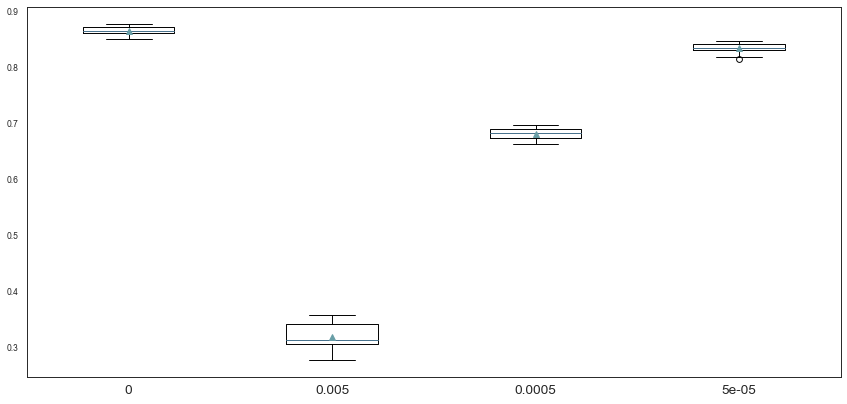

In [315]:
#alpha

def get_models(values):
    models = dict()
    for value in values:
        models[str(value)] = RandomForestClassifier(ccp_alpha = value, random_state = 9)      
    return models

models = get_models([0,0.005,0.0005,0.00005])
return_results(models)

### Final Result

In [326]:
modelRFT = RandomForestClassifier(
                                 class_weight = 'balanced',
                                 min_samples_leaf = 2,
                                 min_samples_split = 4,
                                  max_depth = 80,
                                  criterion = 'entropy',
                                 n_estimators = 100,
                                  ).fit(X_train, y_train)

y_pred_val=modelRFT.predict(X_val)

print('Accuracy score:', accuracy_score(y_val,y_pred_val))
print('F1 score:', f1_score(y_val,y_pred_val))

Accuracy score: 0.9209245742092458
F1 score: 0.8602150537634408


In [327]:
avg_score(modelRFT, X, y, X.columns)

('0.991+/-0.0', '0.924+/-0.0', '0.865+/-0.01', 0.865)